# About Dataset

- Features **V1, V2, … V28** are the principal components obtained with PCA
- Feature **'Time'** contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature **'Amount'** is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
- Feature **'Class'** is the response variable and it takes value **1** in case of **fraud** and **0 otherwise**.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## read data

In [2]:
train = pd.read_csv(r"E:\My_Github\Credit Card Fraud Detection\data\train.csv")
val =  pd.read_csv(r"E:\My_Github\Credit Card Fraud Detection\data\val.csv")

In [3]:
train.shape

(170884, 31)

In [4]:
val.shape

(56960, 31)

In [5]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,119191.0,2.052427,-0.133236,-1.740621,0.277935,0.337999,-0.826933,0.334629,-0.227039,0.267655,...,-0.006518,0.121300,0.037733,-0.356498,0.147822,0.569149,-0.103929,-0.091958,8.73,0
1,71750.0,1.220356,-0.159191,-0.444349,-0.094437,0.104457,-0.345790,0.170867,-0.094996,0.187572,...,-0.088775,-0.364654,-0.140851,-0.707308,0.415661,1.087767,-0.102532,-0.008335,59.95,0
2,151977.0,0.892824,-1.440698,-0.637940,3.912871,0.099291,2.433288,-0.308891,0.603227,-0.113826,...,0.484969,0.487304,-0.122694,-0.598803,-0.594563,0.062841,-0.033426,0.038254,460.65,0
3,55709.0,-3.146021,2.247634,0.901397,0.146162,-2.109360,-0.148312,-1.533191,2.073663,0.499394,...,0.050567,-0.037019,0.107000,0.392857,0.303597,0.379544,-0.148990,0.074965,4.78,0
4,66654.0,1.194996,-0.007495,0.301285,0.750199,-0.297494,-0.405836,0.060410,-0.150482,0.400860,...,-0.234931,-0.545566,-0.089418,-0.064036,0.527305,0.294221,-0.025980,0.015637,44.31,0


## Check Missing Data

In [6]:
train.isna().sum().sum()

0

In [7]:
val.isna().sum().sum()

0

There is no missing data in the dataset.

# Understanding Data

In [8]:
train.shape

(170884, 31)

In [9]:
val.shape

(56960, 31)

In [10]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170884 entries, 0 to 170883
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    170884 non-null  float64
 1   V1      170884 non-null  float64
 2   V2      170884 non-null  float64
 3   V3      170884 non-null  float64
 4   V4      170884 non-null  float64
 5   V5      170884 non-null  float64
 6   V6      170884 non-null  float64
 7   V7      170884 non-null  float64
 8   V8      170884 non-null  float64
 9   V9      170884 non-null  float64
 10  V10     170884 non-null  float64
 11  V11     170884 non-null  float64
 12  V12     170884 non-null  float64
 13  V13     170884 non-null  float64
 14  V14     170884 non-null  float64
 15  V15     170884 non-null  float64
 16  V16     170884 non-null  float64
 17  V17     170884 non-null  float64
 18  V18     170884 non-null  float64
 19  V19     170884 non-null  float64
 20  V20     170884 non-null  float64
 21  V21     17

# Dataset Summary Statistics

In [12]:
with pd.option_context('display.max_columns', None, 'display.width', None):
    print(train.describe())

                Time             V1             V2             V3  \
count  170884.000000  170884.000000  170884.000000  170884.000000   
mean    94966.107886      -0.001070      -0.000904      -0.002722   
std     47464.723773       1.958944       1.650481       1.521820   
min         0.000000     -46.855047     -63.344698     -48.325589   
25%     54348.000000      -0.922071      -0.599127      -0.896376   
50%     84923.500000       0.016603       0.065839       0.177007   
75%    139404.000000       1.316250       0.802518       1.028302   
max    172792.000000       2.451888      22.057729       4.226108   

                  V4             V5             V6             V7  \
count  170884.000000  170884.000000  170884.000000  170884.000000   
mean       -0.002603       0.000151       0.000779      -0.000811   
std         1.416490       1.394123       1.338331       1.260122   
min        -5.683171    -113.743307     -23.496714     -43.557242   
25%        -0.848978      -0.6918

# Data exploration

## Class distribution

In [13]:
freq_Class_count = train['Class'].value_counts()
freq_Class_count

Class
0    170579
1       305
Name: count, dtype: int64

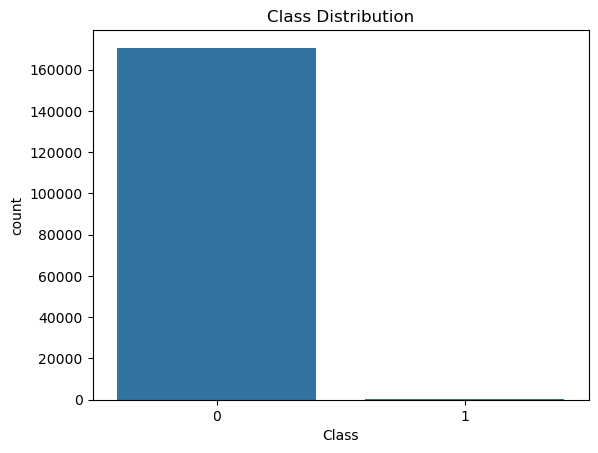

In [14]:
sns.countplot(x=train['Class'])
plt.title("Class Distribution")
plt.show()

 The data is highly imbalanced.

## Features Distribution
Plot a **histogram** for each numerical attribute to visualize its **distribution**. 📊

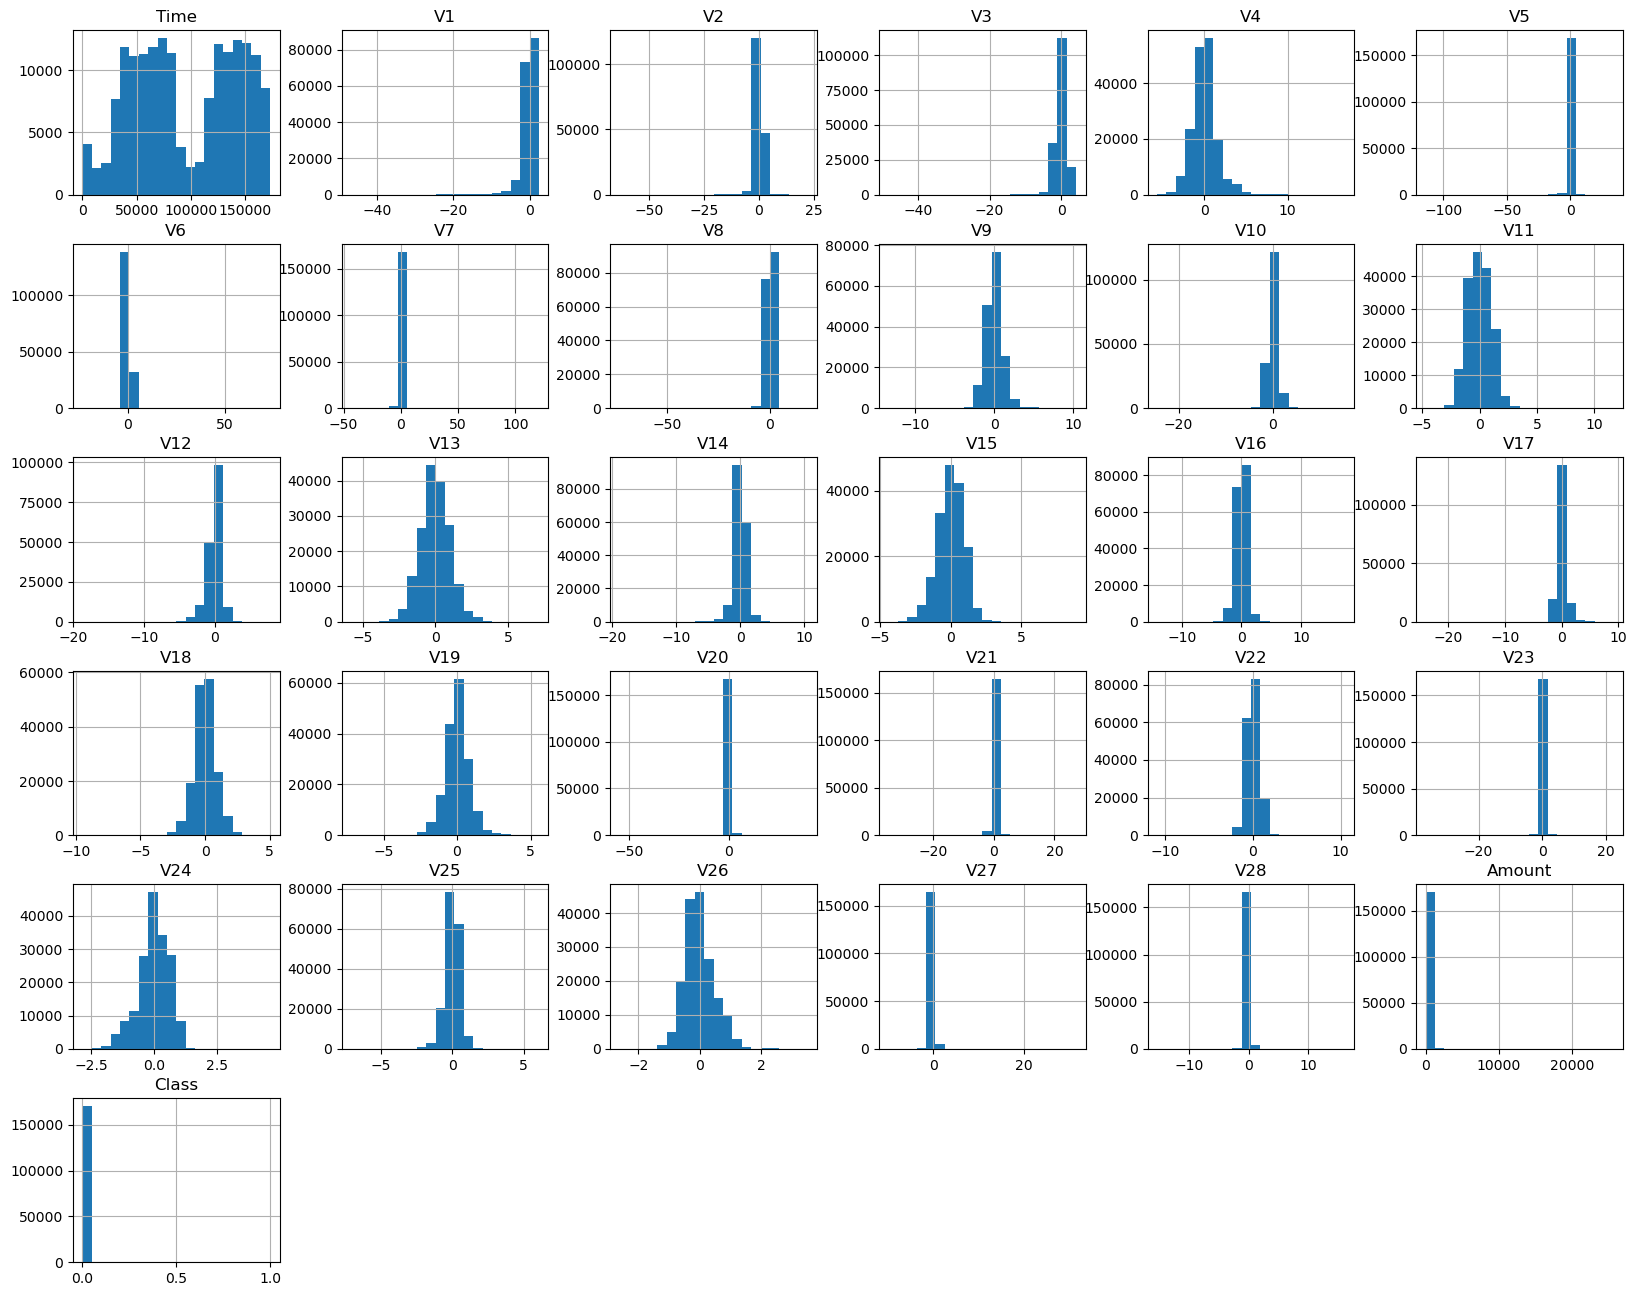

In [15]:
train.hist(bins=20, figsize=(20, 16))
plt.show()

Distribution of the **Amount feature:**

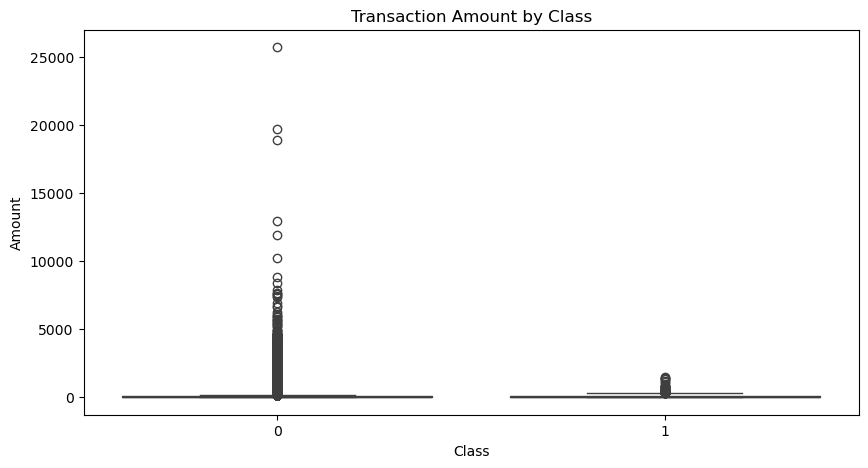

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=train['Class'], y=train['Amount'])
plt.title("Transaction Amount by Class")
plt.show()

## fraud vs non-fraud

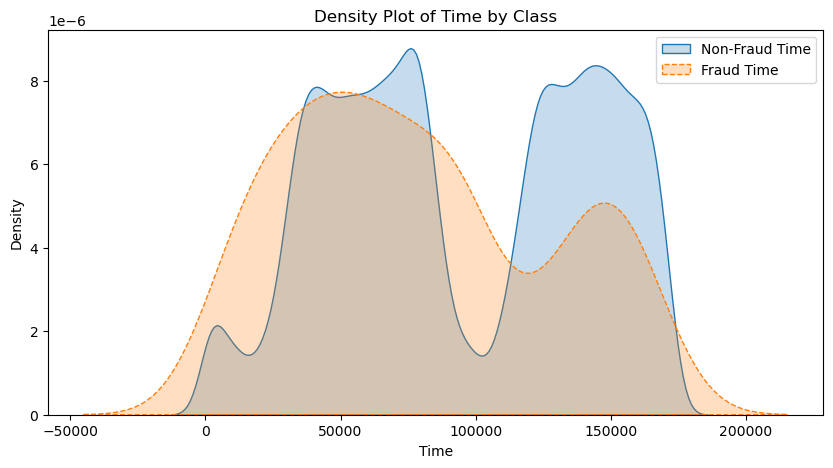

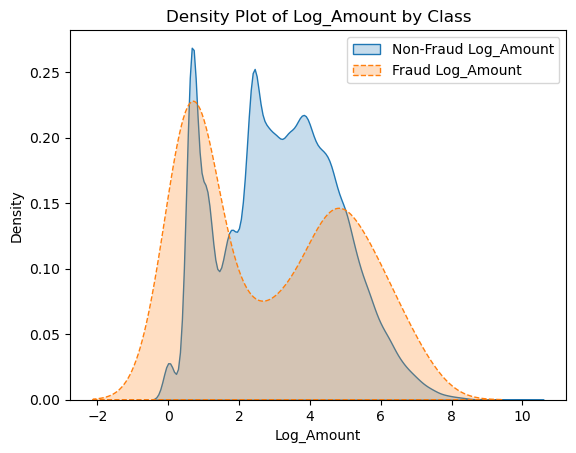

In [17]:
# KDE plot [Time, Log_Amount] features for fraud vs non-fraud
train_data = train.copy()
train_data['Log_Amount'] = np.log1p(train['Amount'])
plt.figure(figsize=(10, 5))
for feature in ['Time', 'Log_Amount']:
    sns.kdeplot(train_data[train_data['Class'] == 0][feature], label=f"Non-Fraud {feature}", fill=True)
    sns.kdeplot(train_data[train_data['Class'] == 1][feature], label=f"Fraud {feature}", fill=True, linestyle="dashed")
    plt.title(f"Density Plot of {feature} by Class")
    plt.legend()
    plt.show()


## Amount VS Time

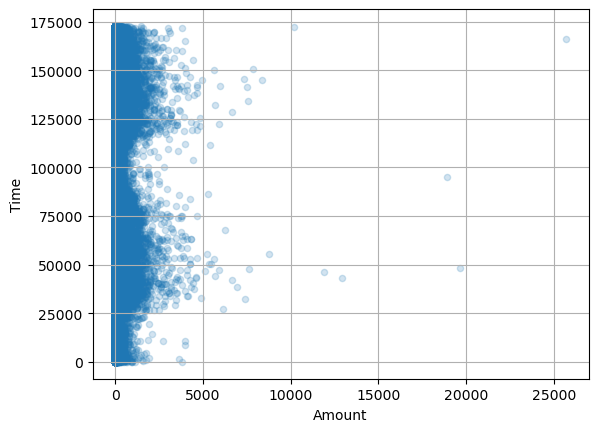

In [18]:
train.plot(kind="scatter", x="Amount", y="Time",
grid=True, alpha=0.2)
plt.show()

## PCA Feature Distributions

Kernel density plots of each PCA-transformed feature (`V1`–`V28`)  
separated by **Fraud** vs **Non-Fraud** classes.

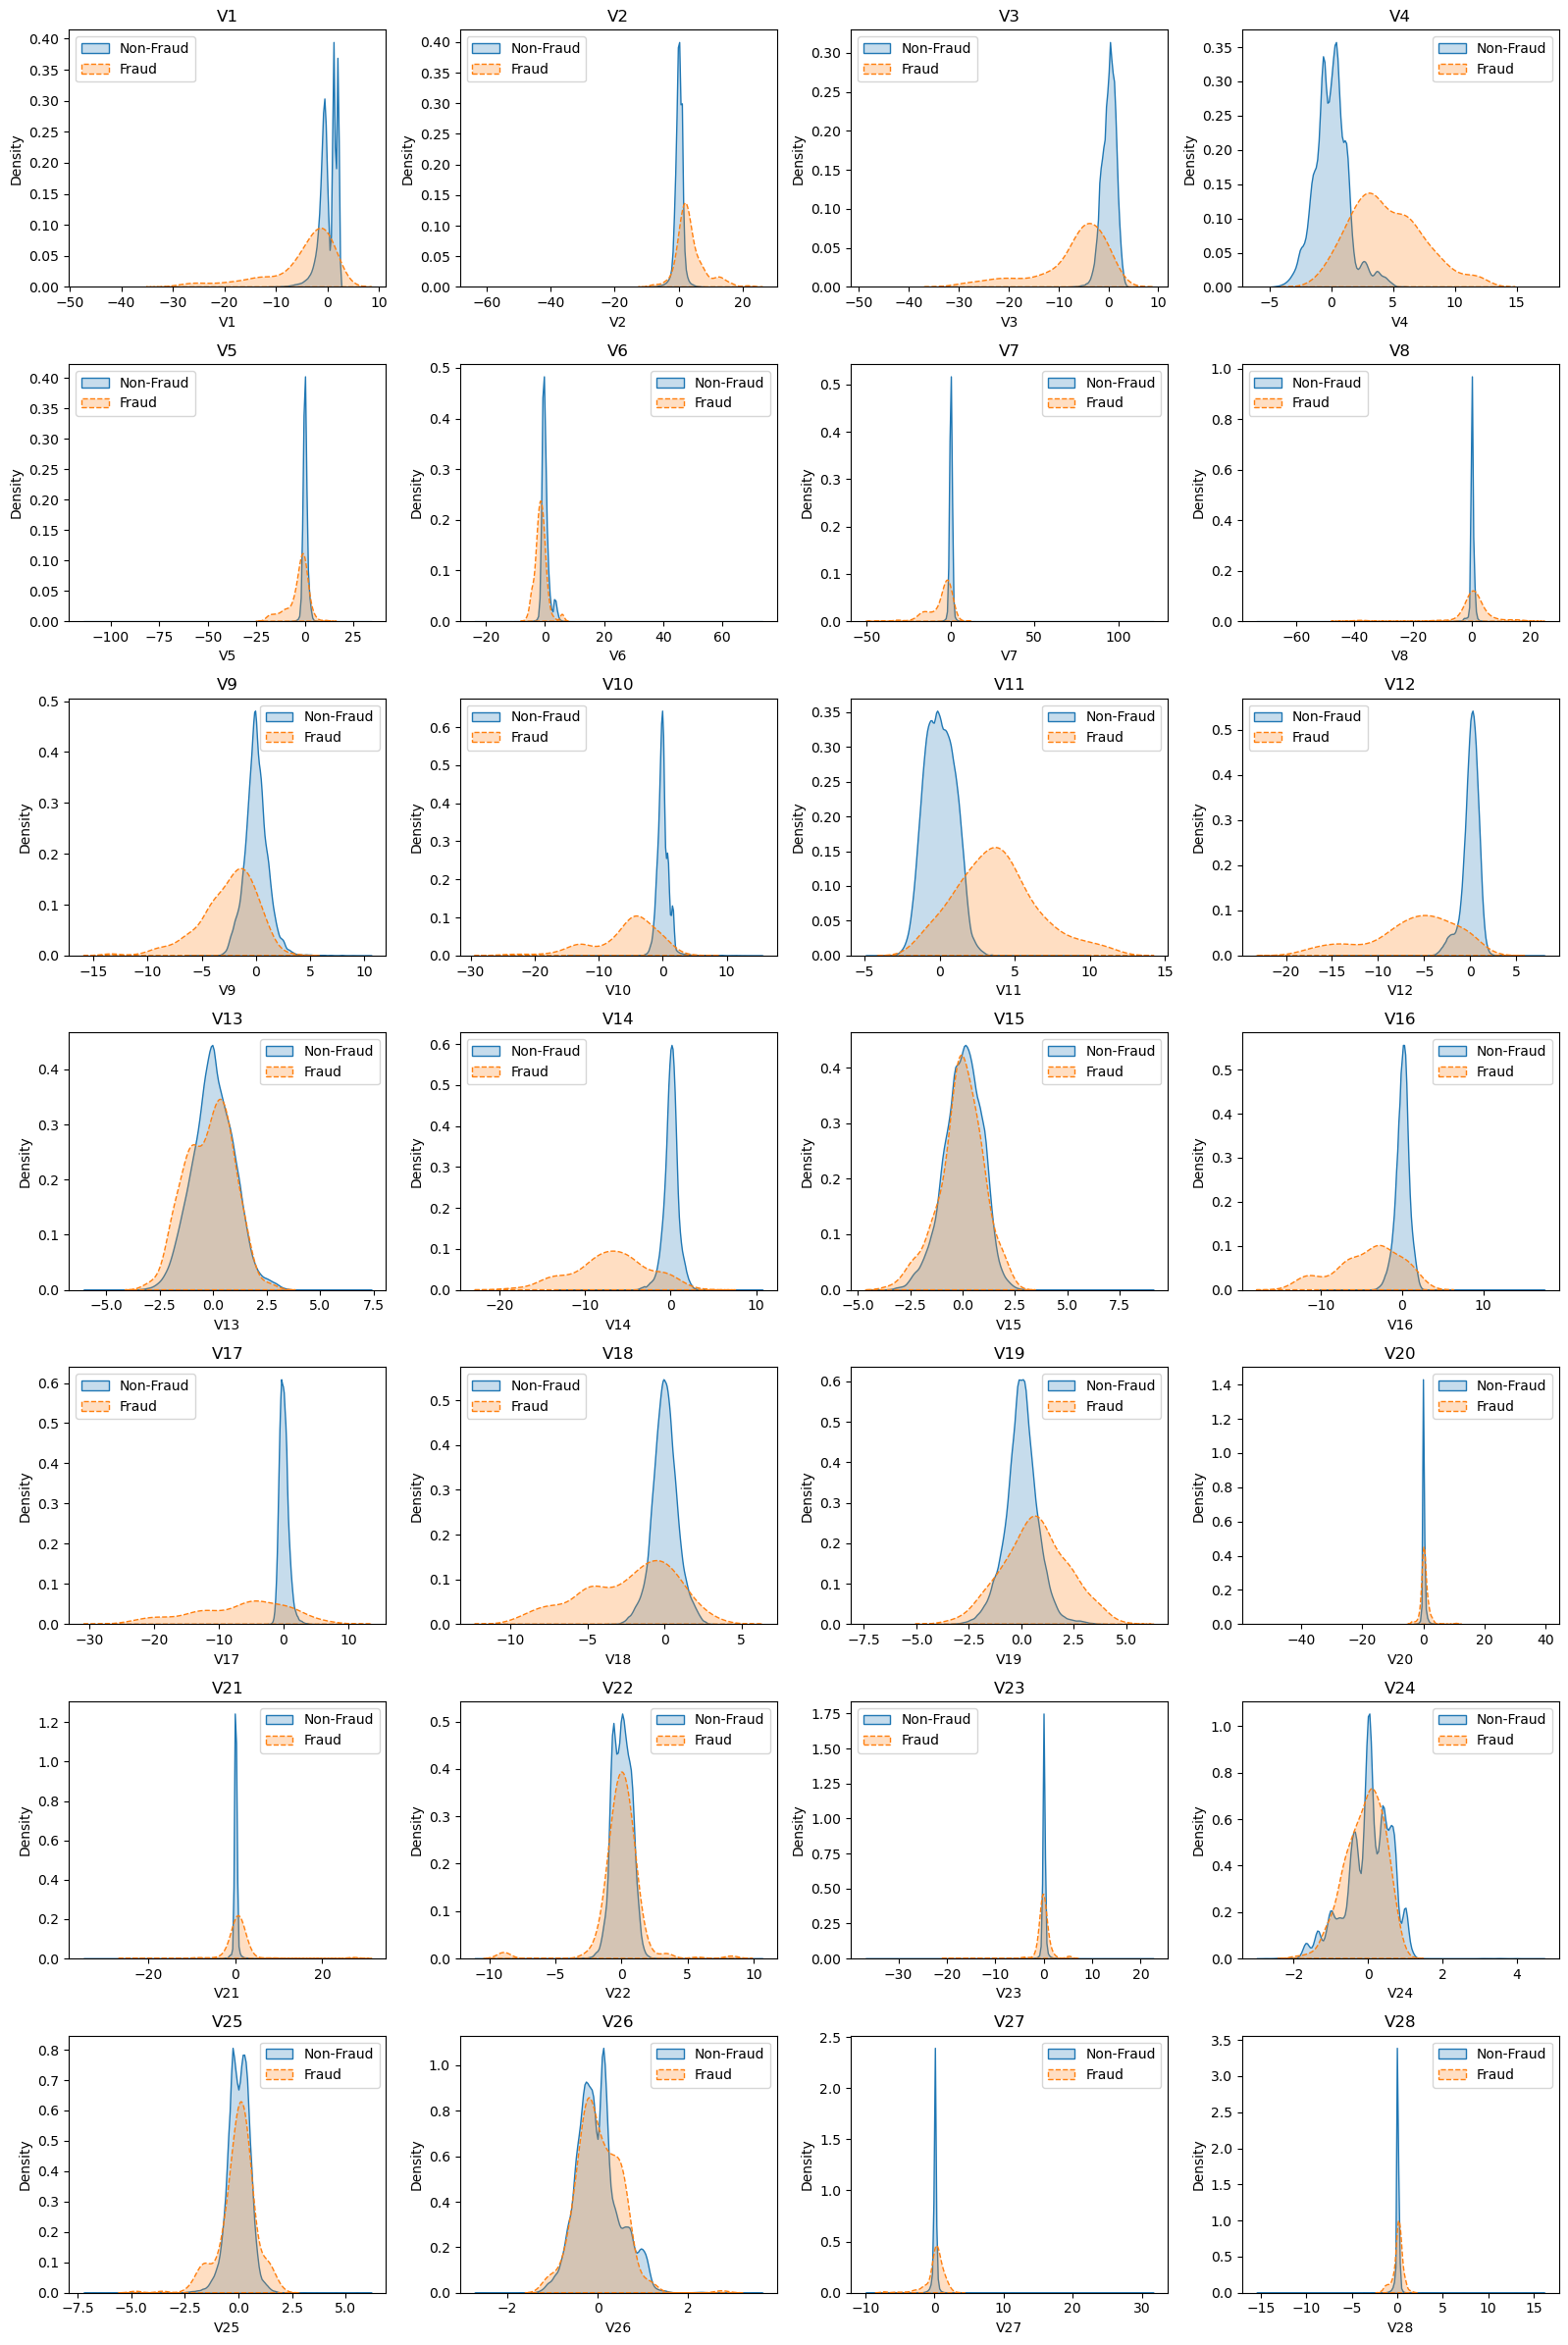

In [19]:
# Select all PCA features
pca_features = [f'V{i}' for i in range(1, 29)]

# Set up subplots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 24)) 
axes = axes.flatten()  # Flatten for easy iteration

# Plot each feature in a separate subplot
for i, feature in enumerate(pca_features):
    sns.kdeplot(train[train['Class'] == 0][feature], label="Non-Fraud", fill=True, ax=axes[i])
    sns.kdeplot(train[train['Class'] == 1][feature], label="Fraud", fill=True, linestyle="dashed", ax=axes[i])
    axes[i].set_title(feature)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Feature Distributions by Class

Boxplots and histograms for each feature,  
separated by **Fraud** vs **Non-Fraud**.

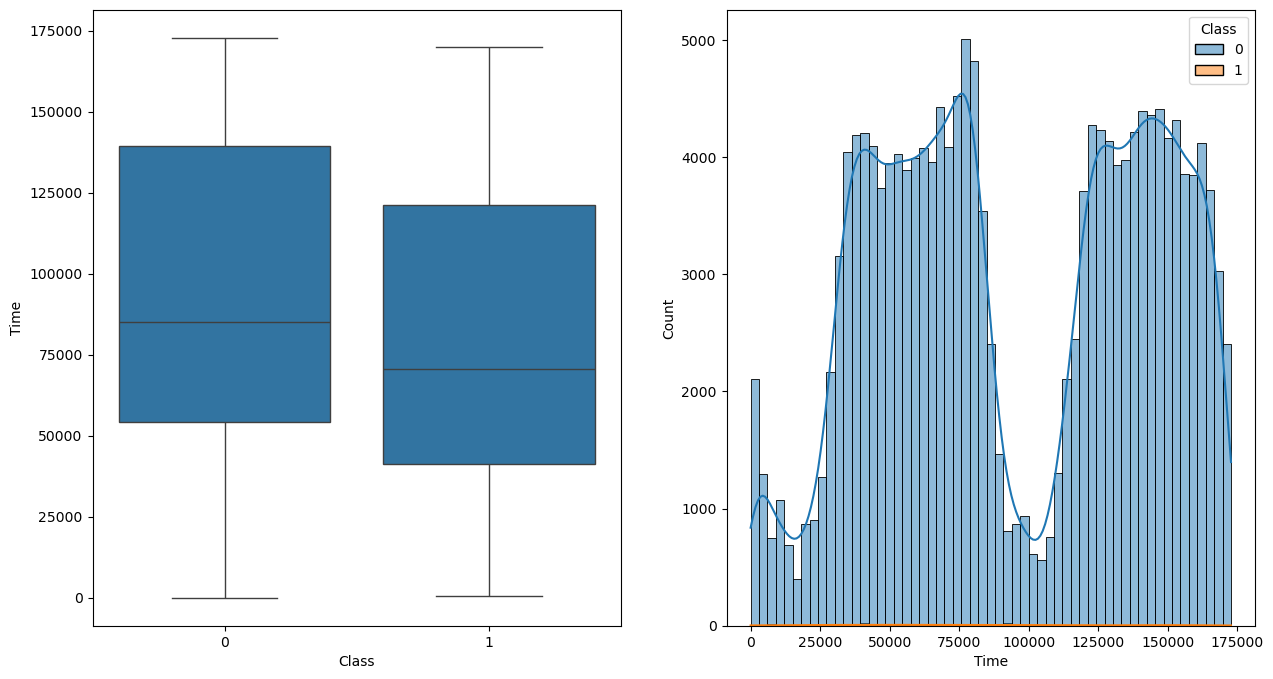

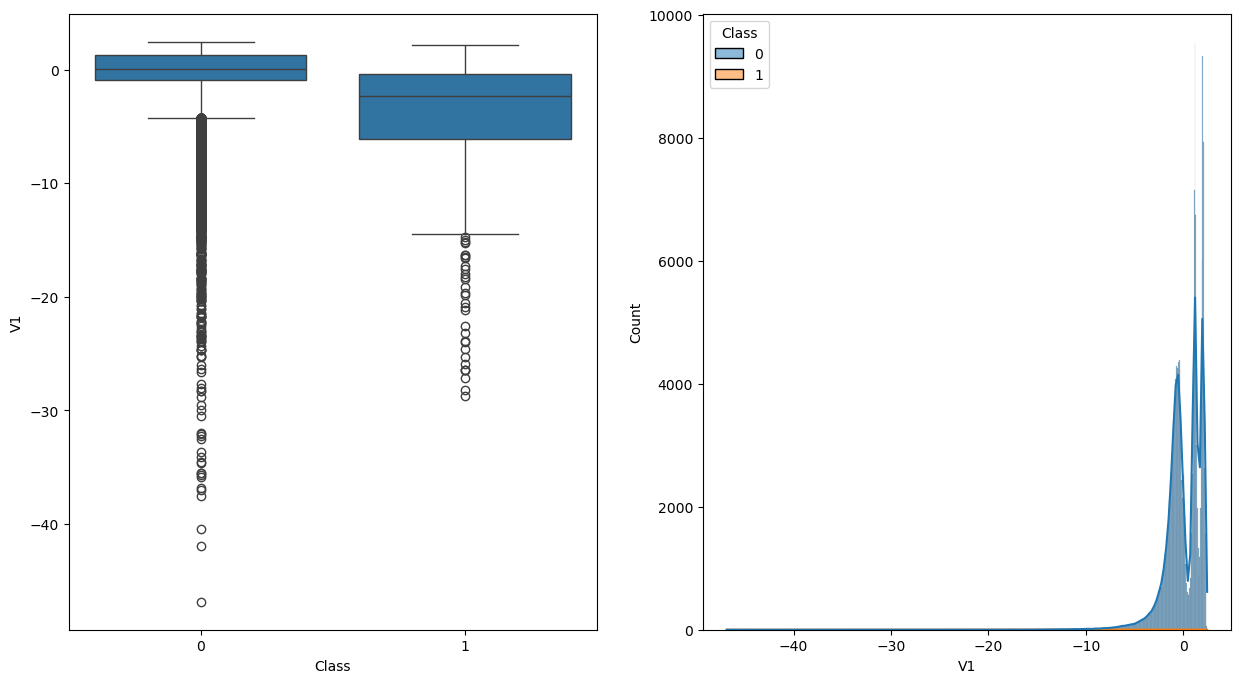

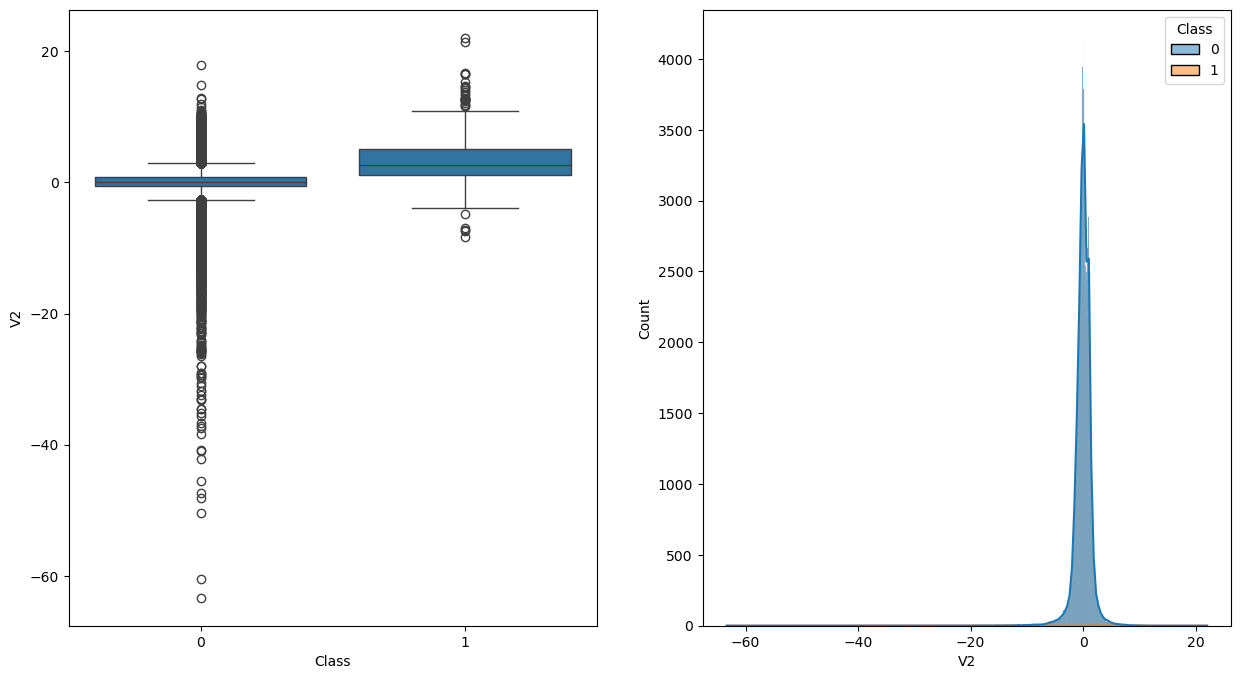

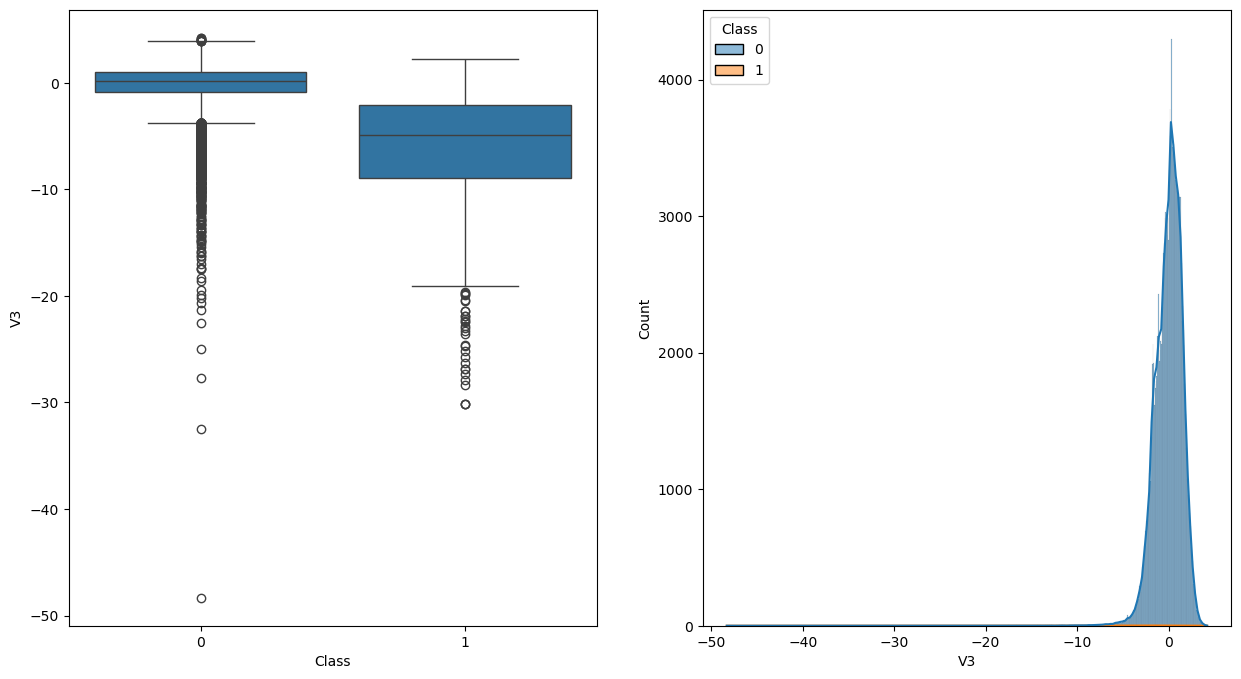

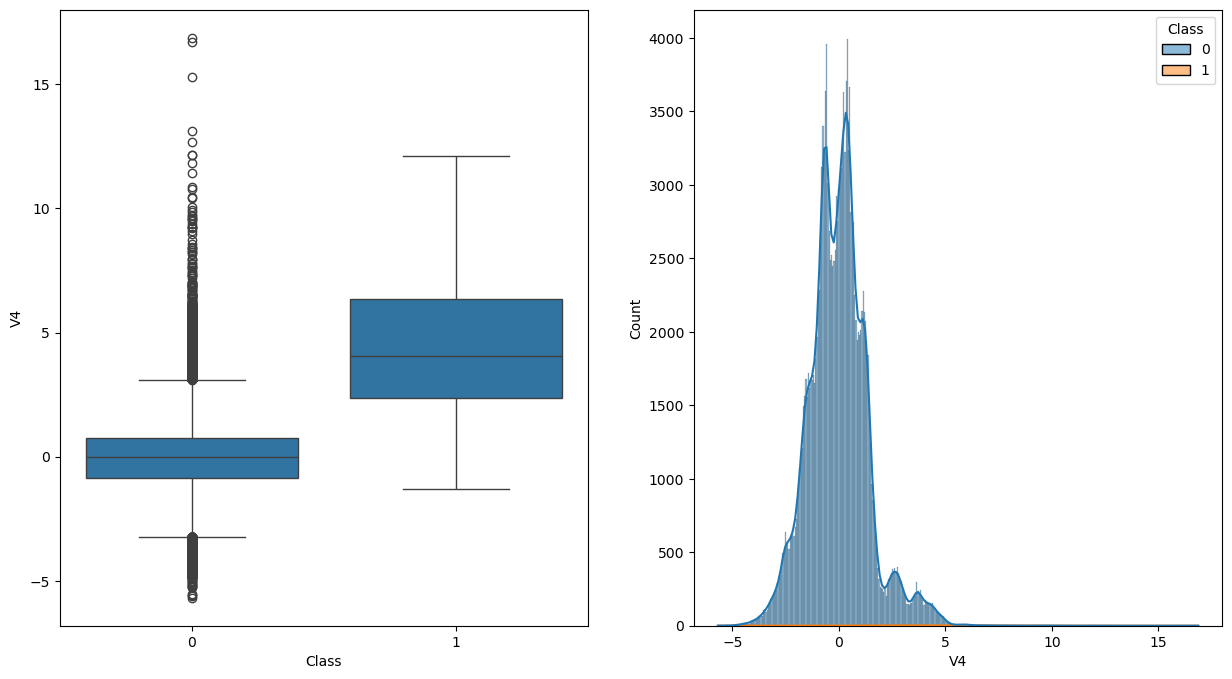

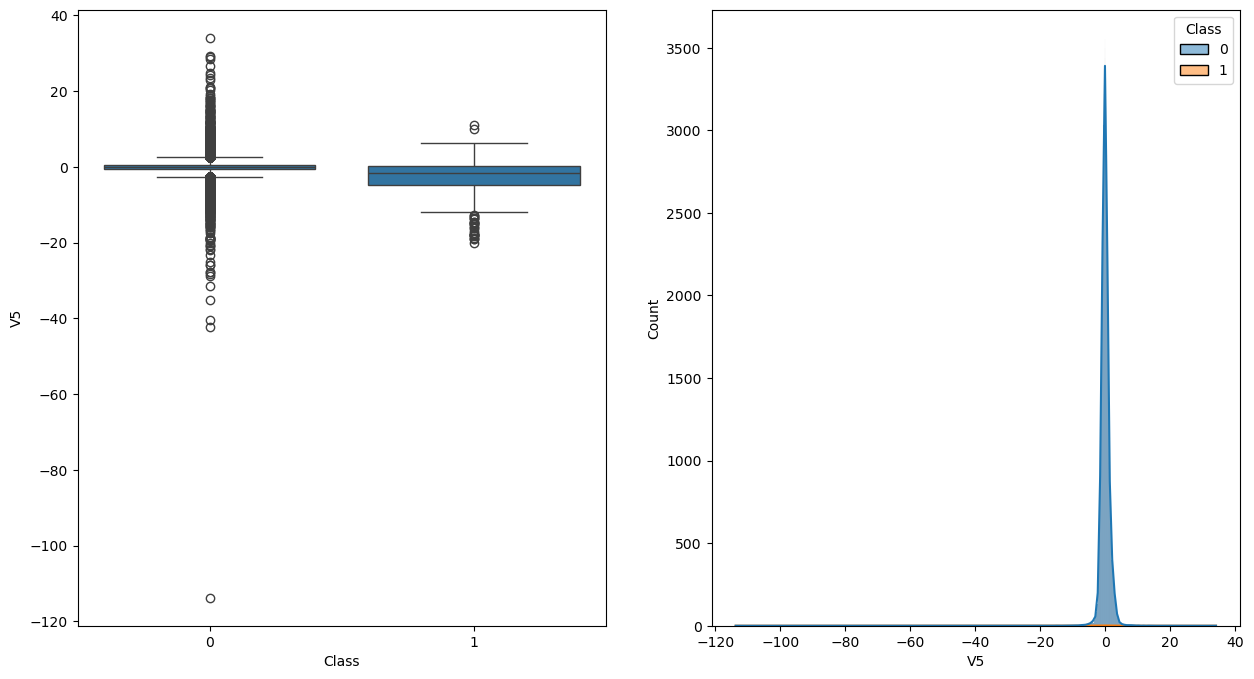

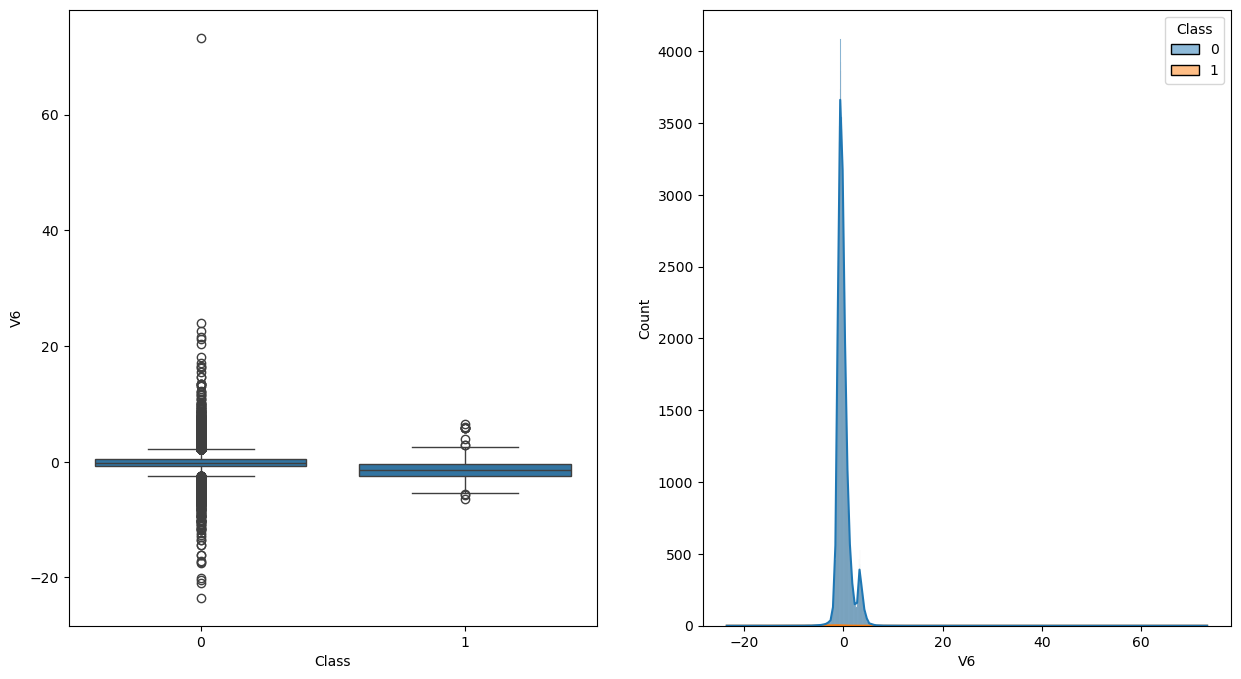

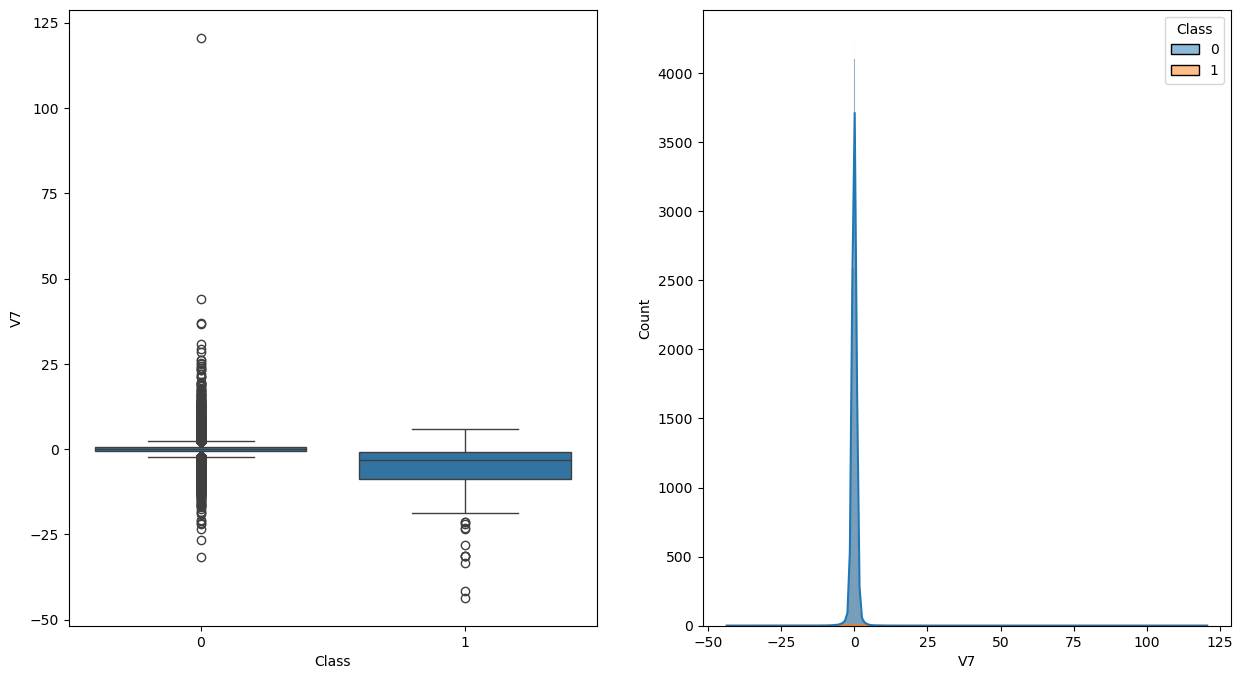

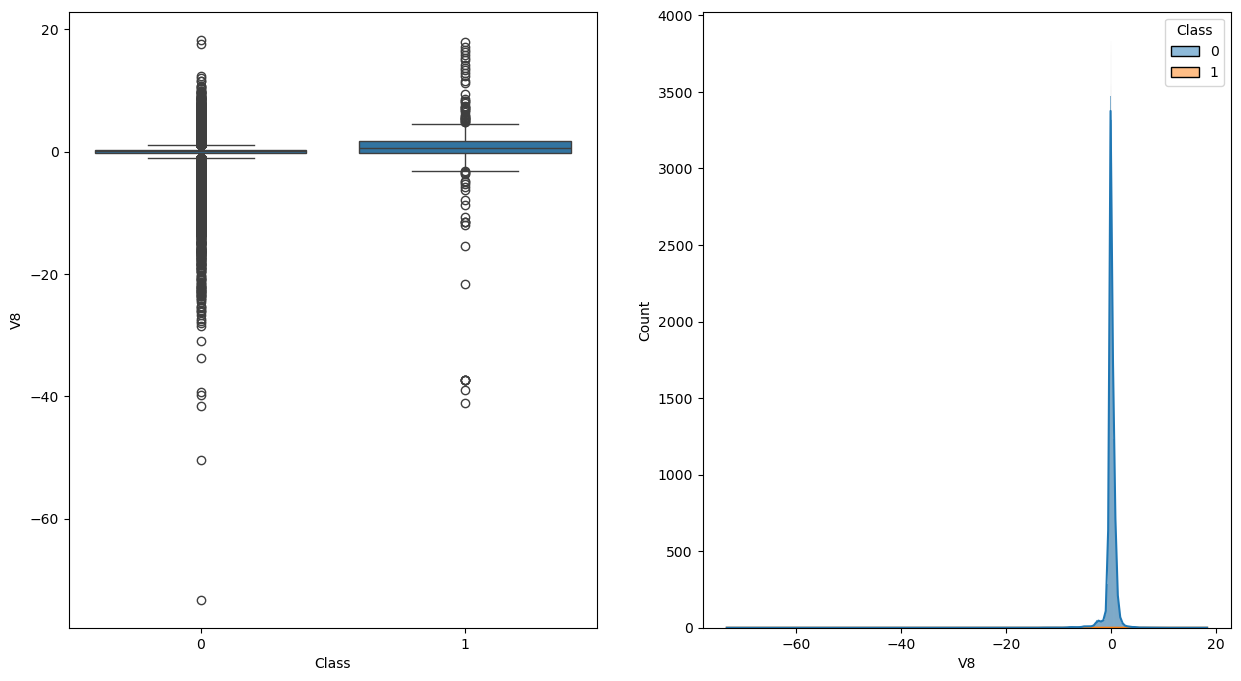

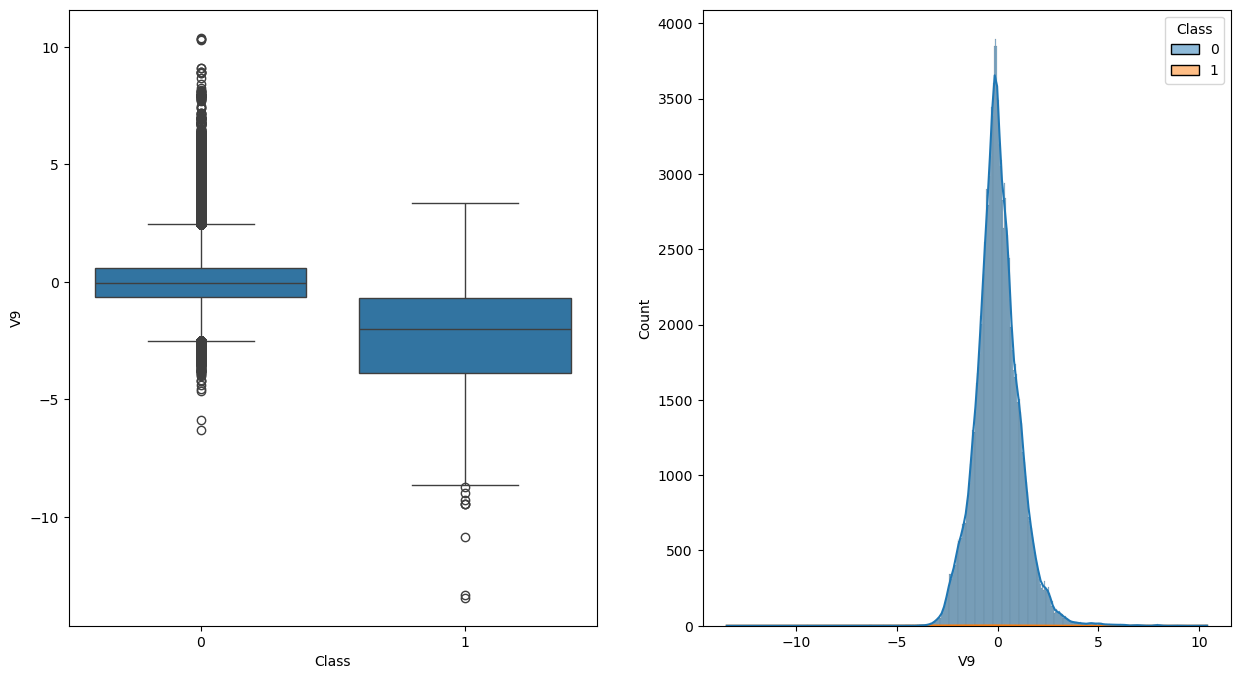

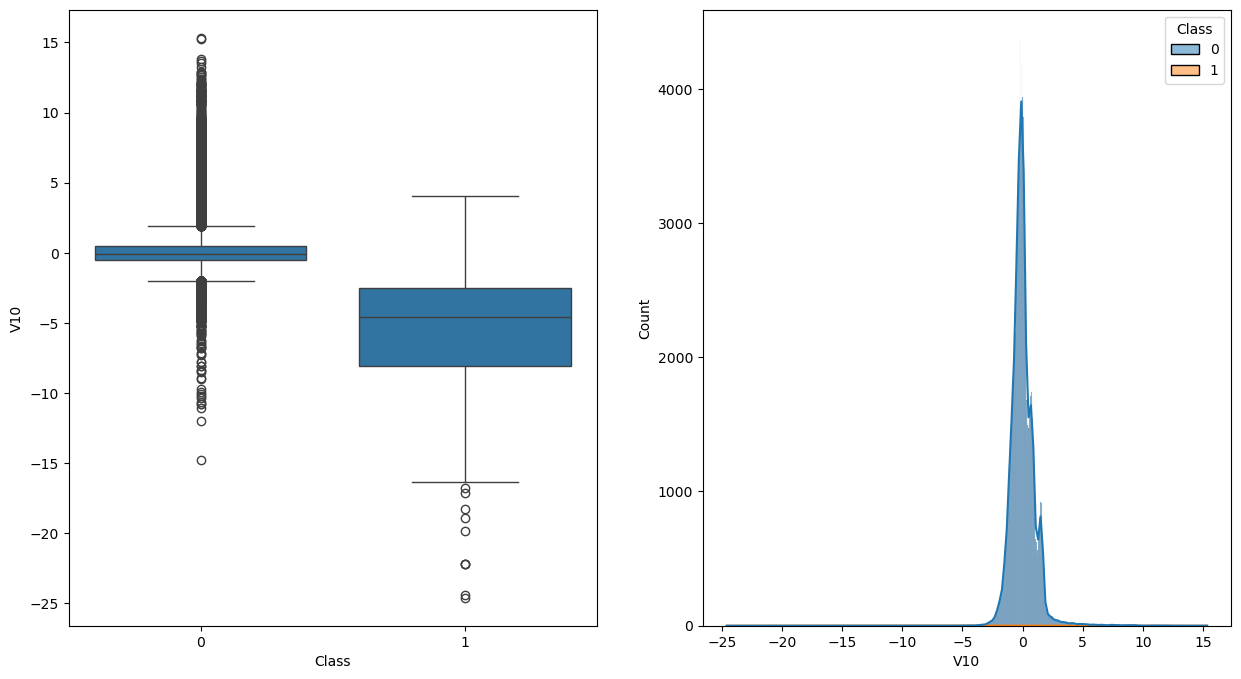

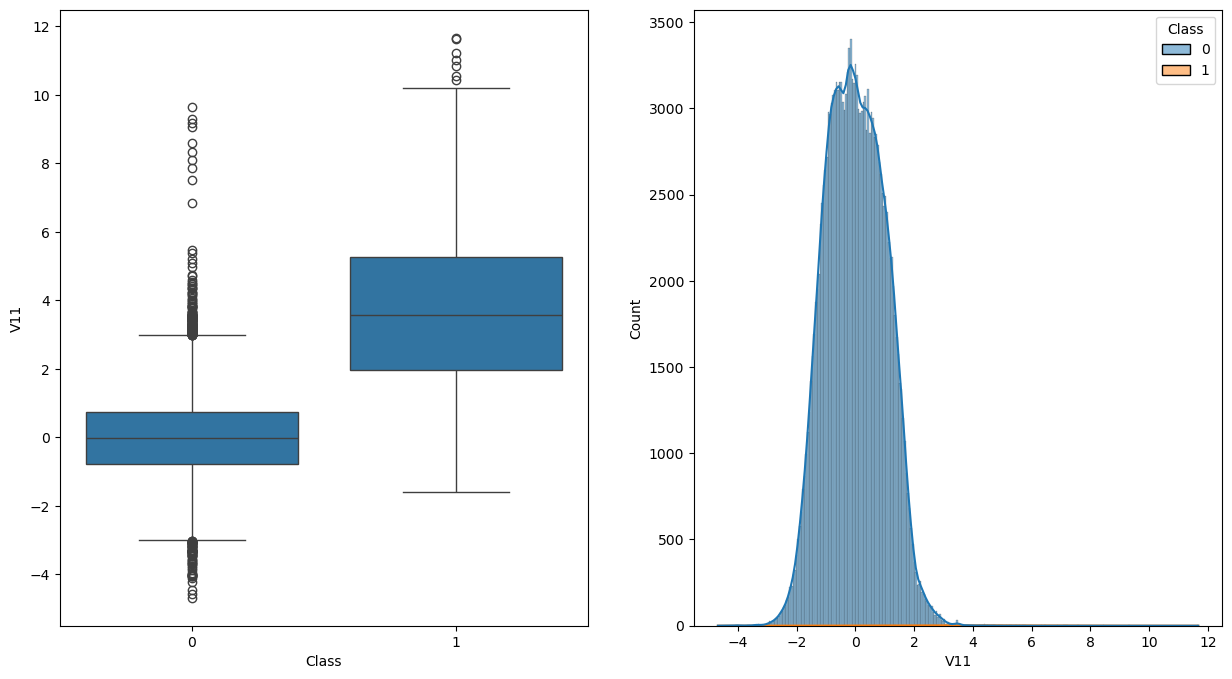

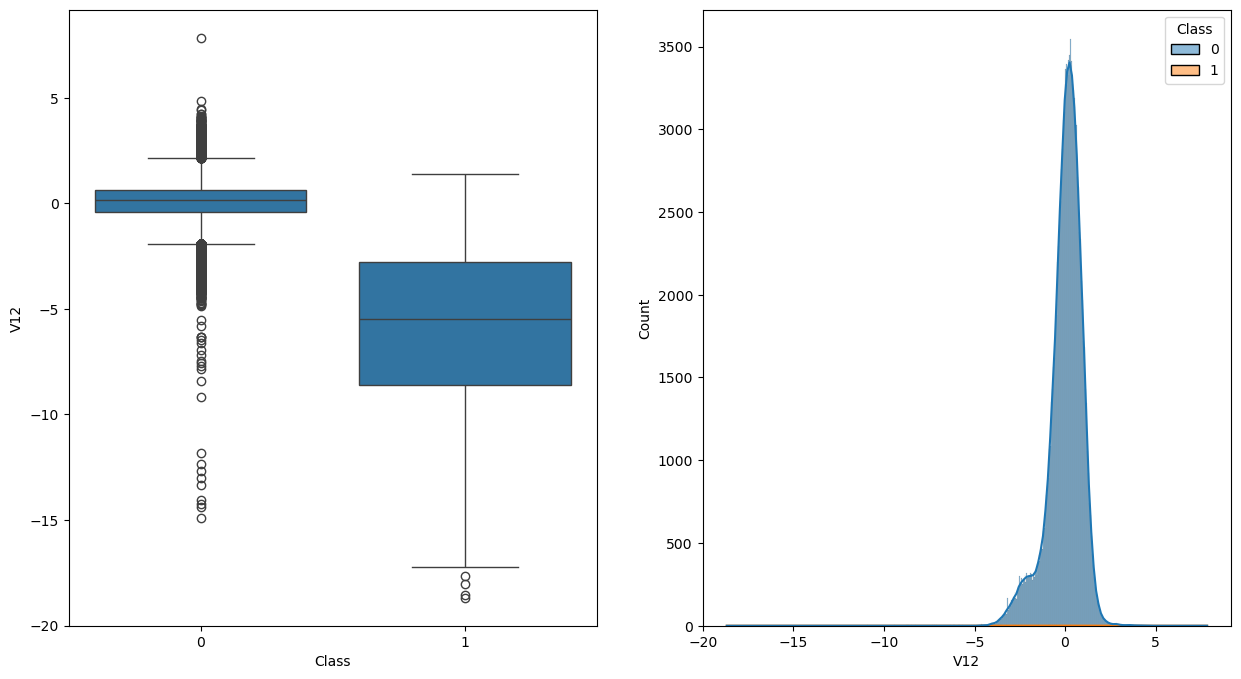

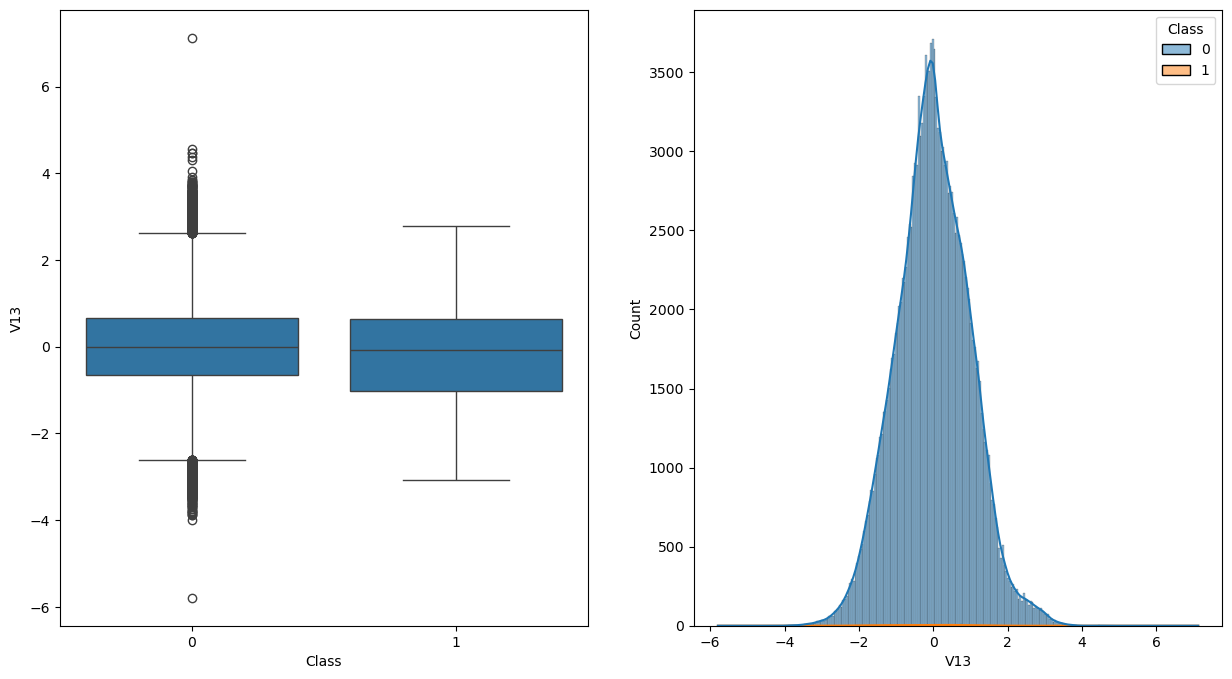

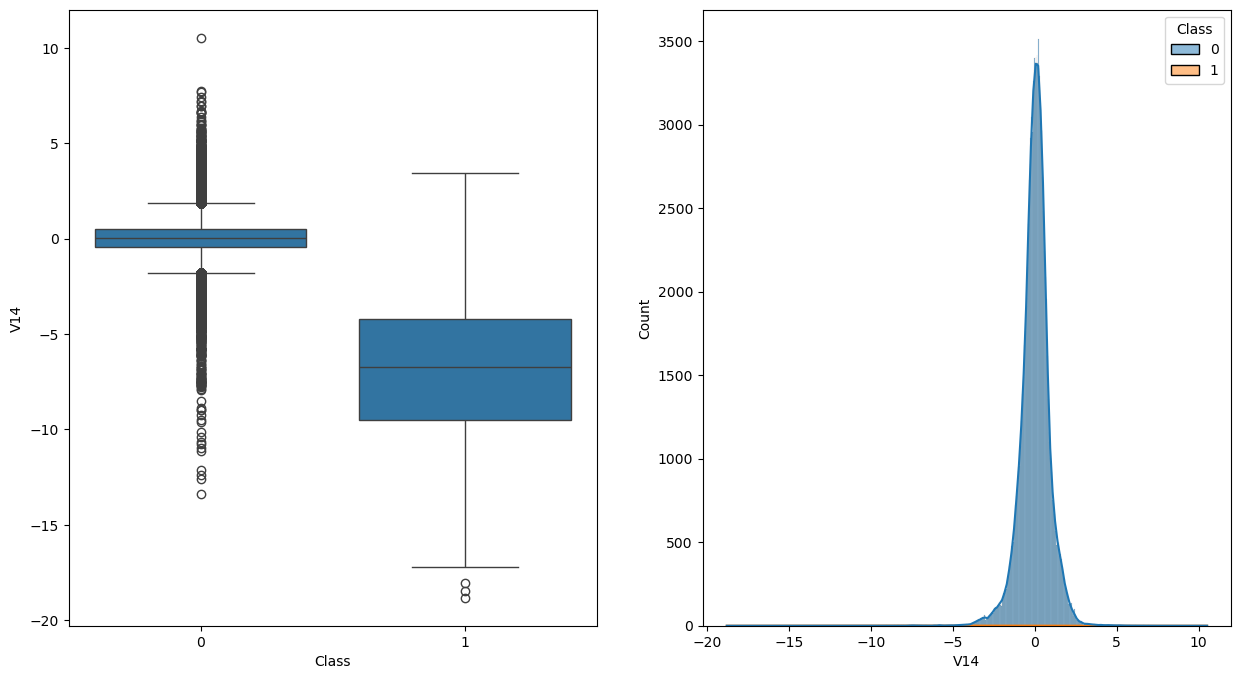

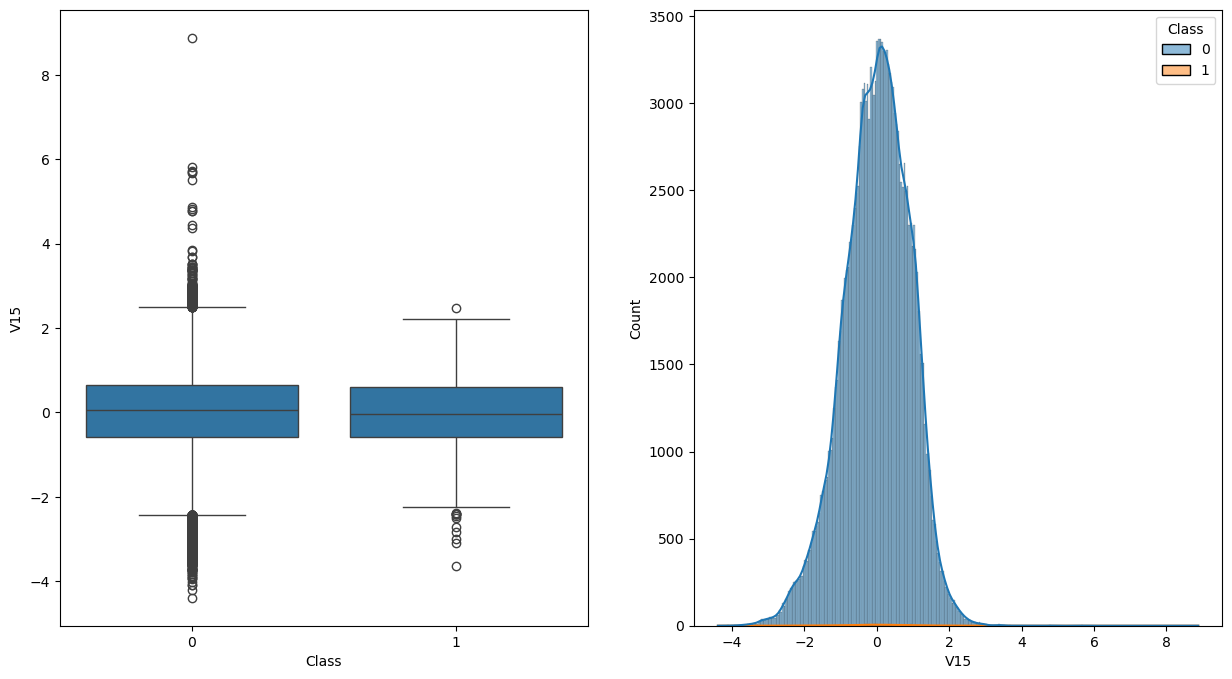

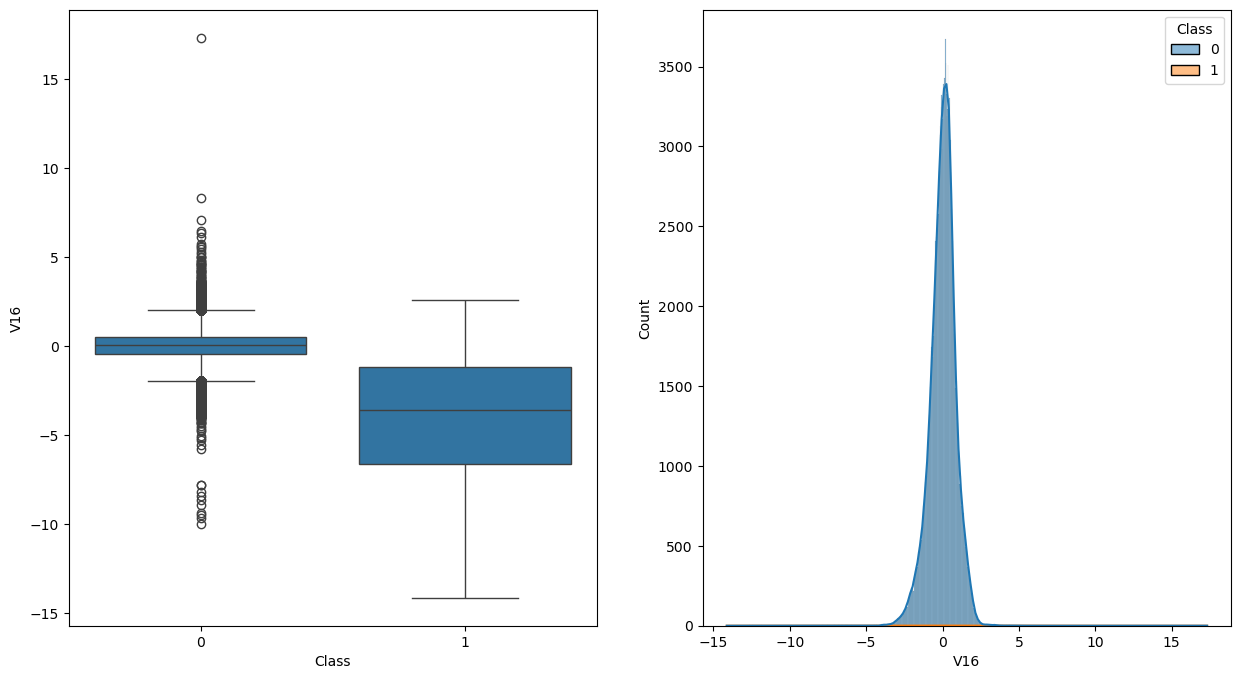

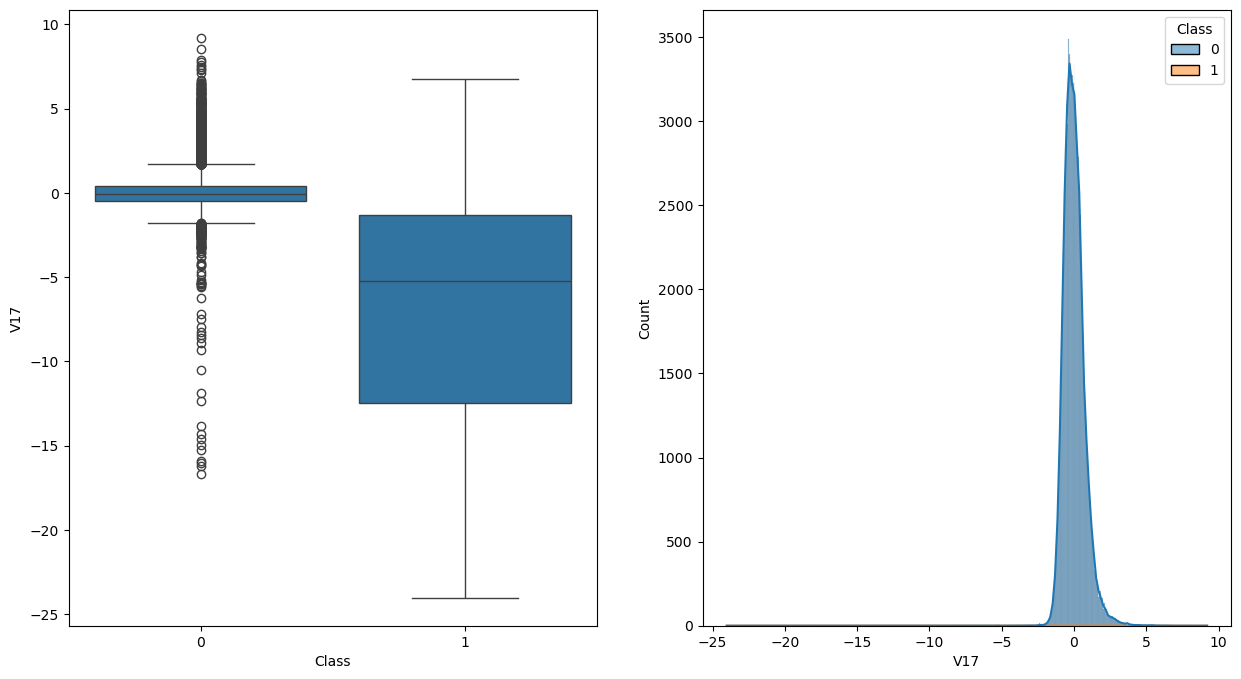

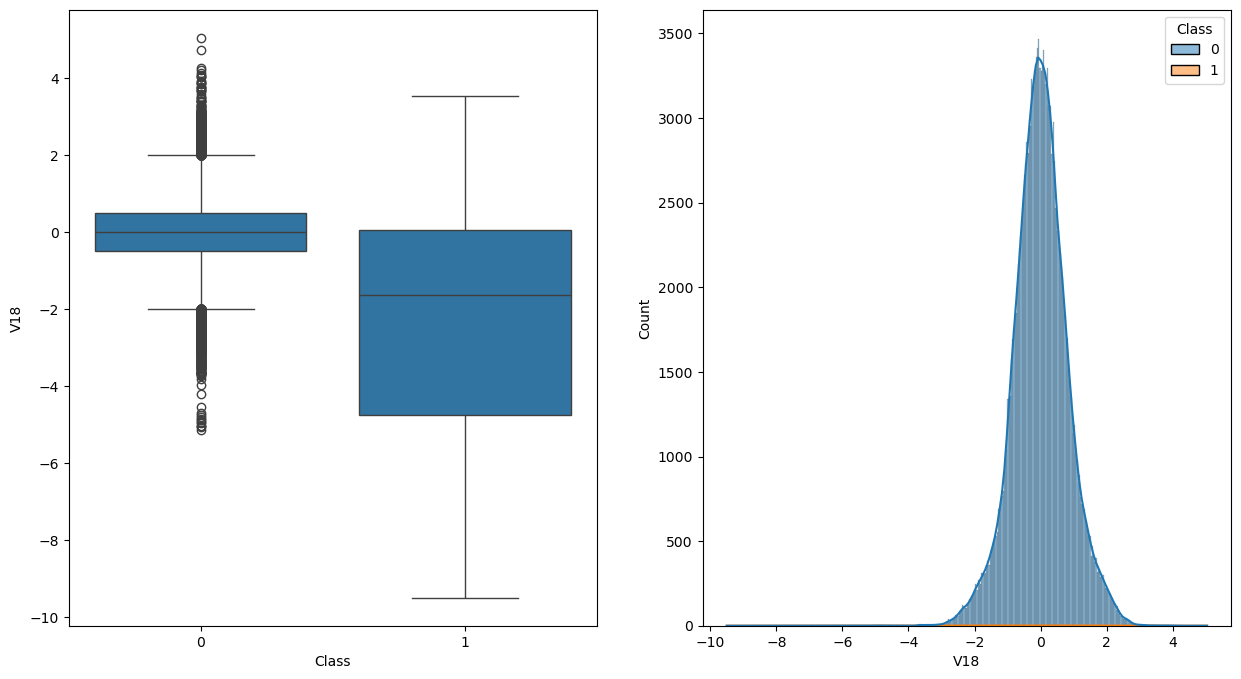

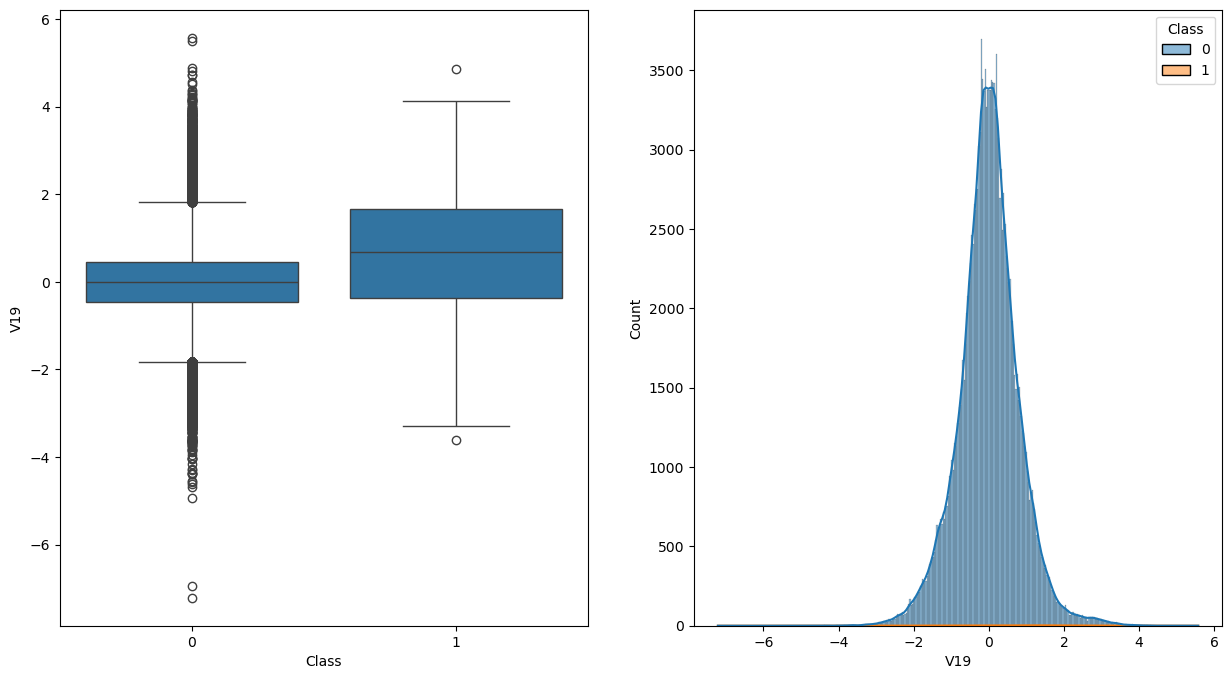

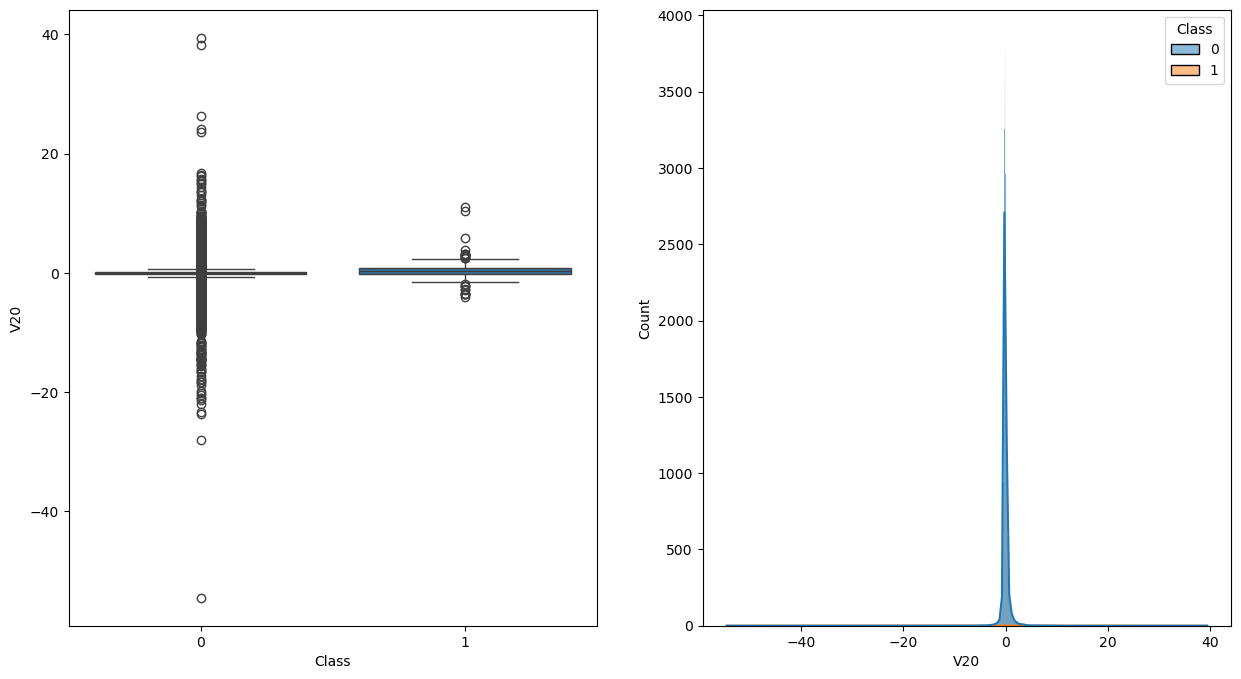

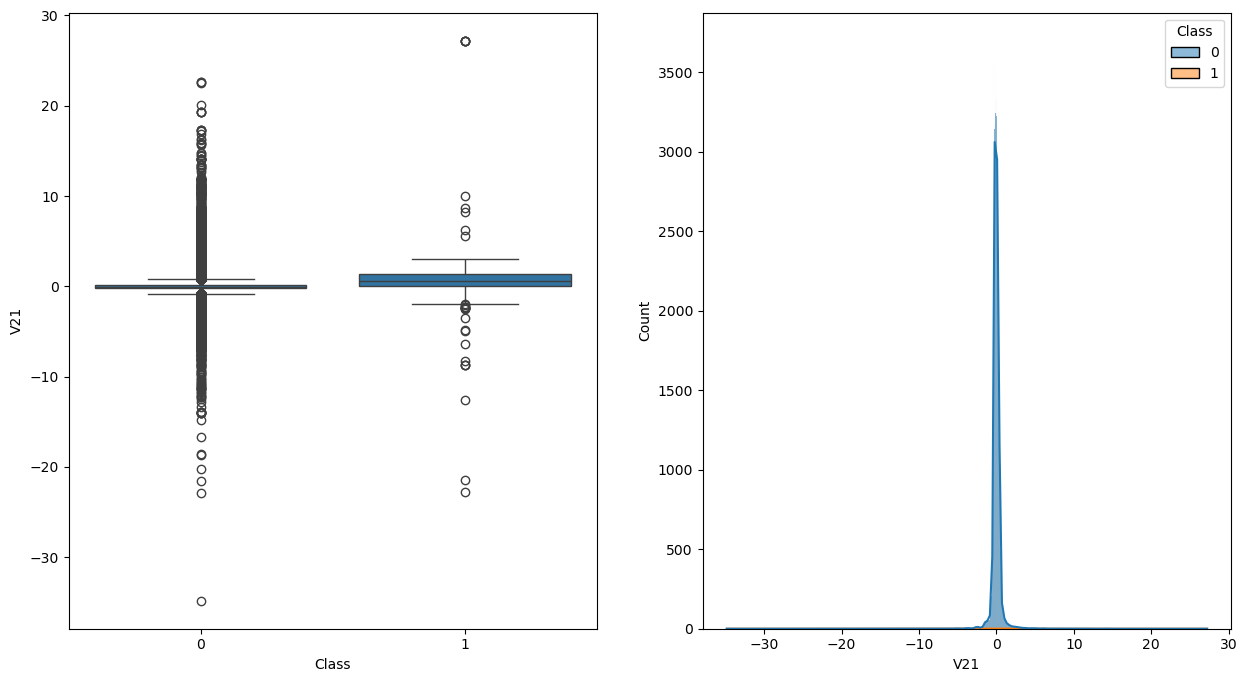

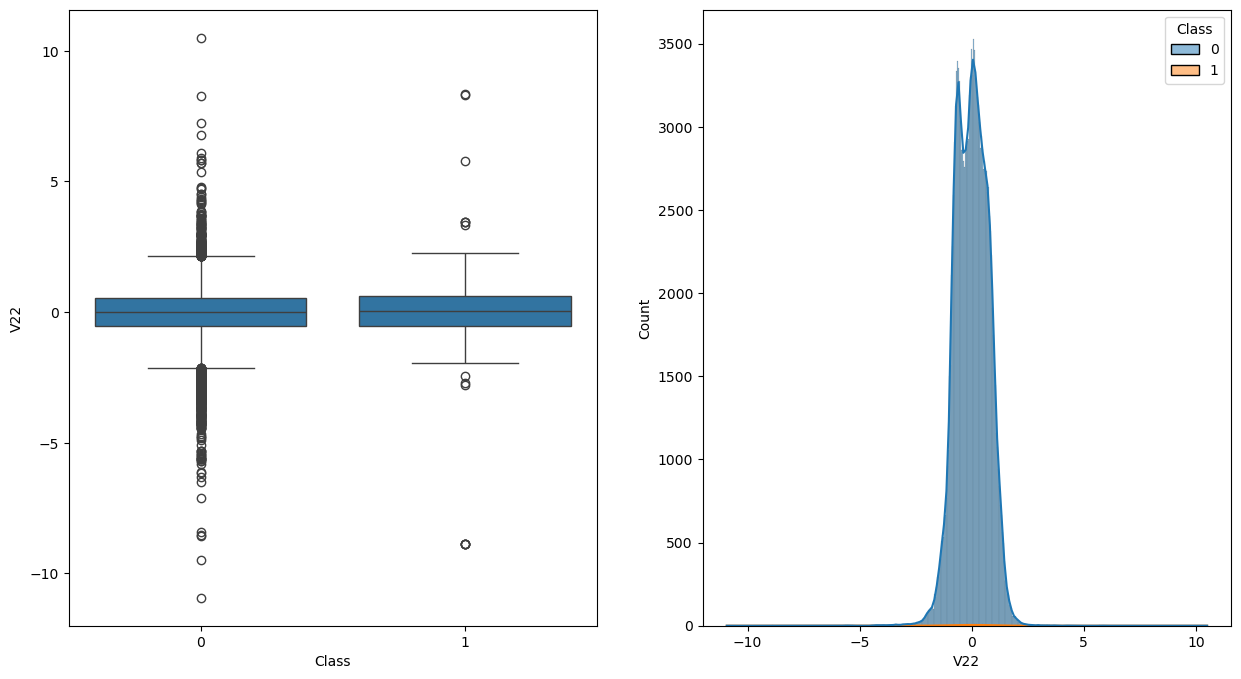

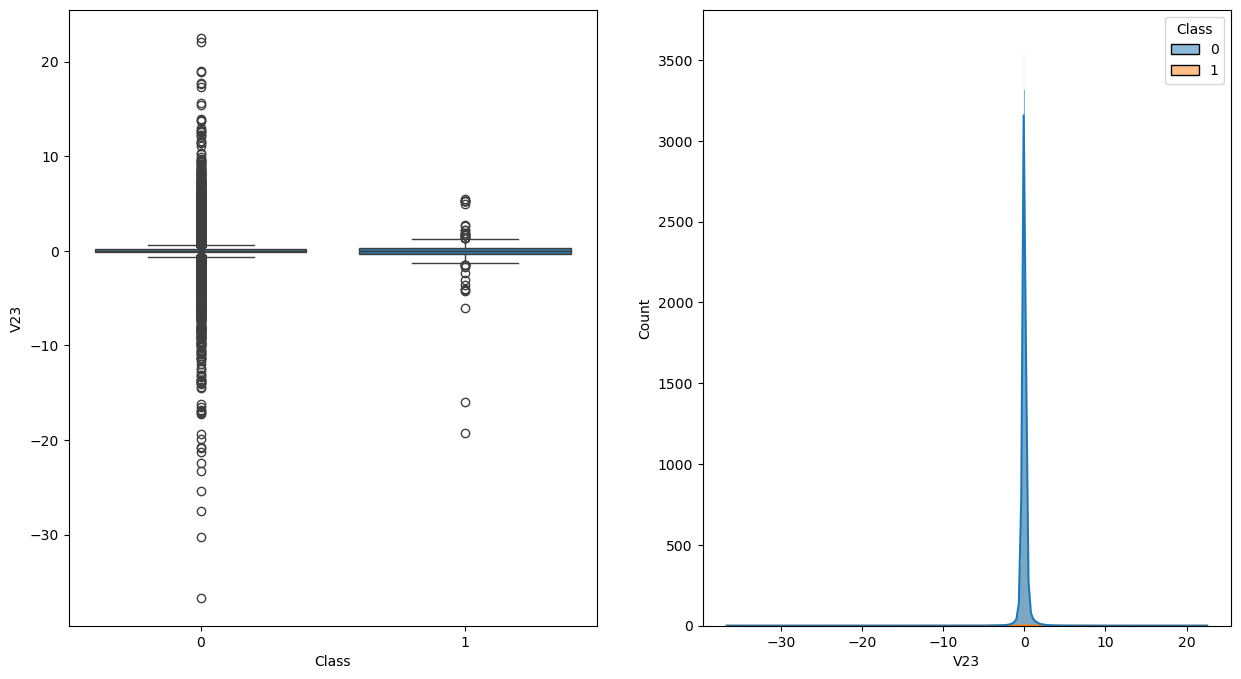

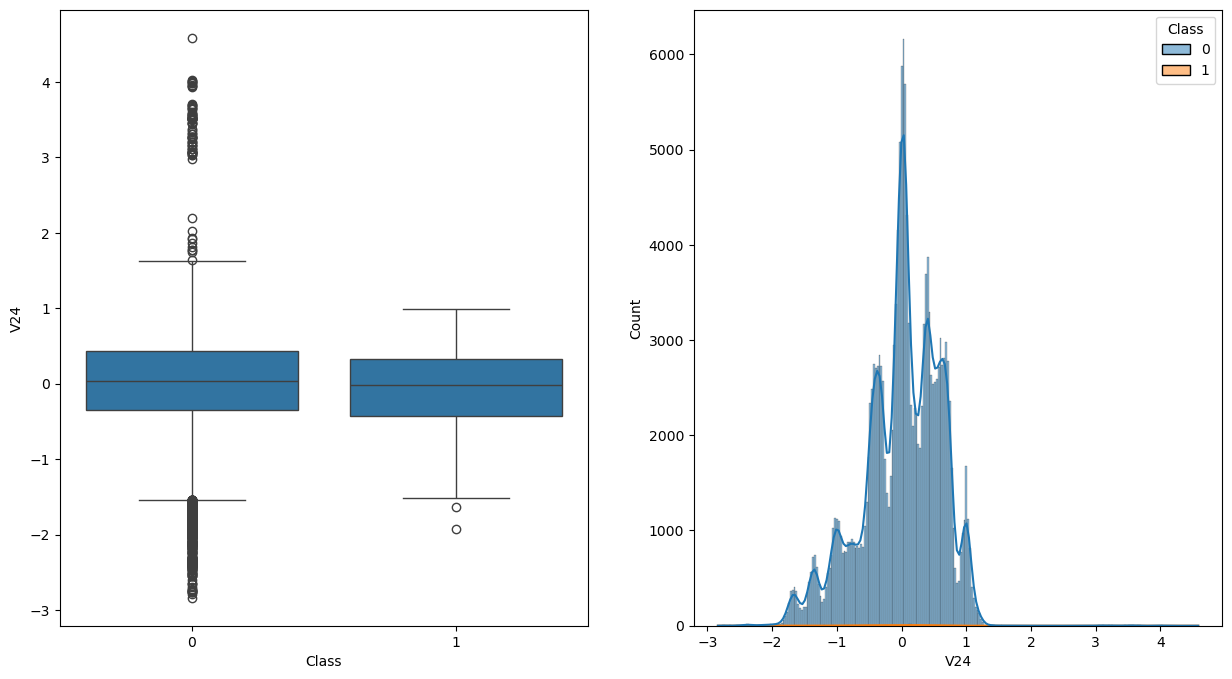

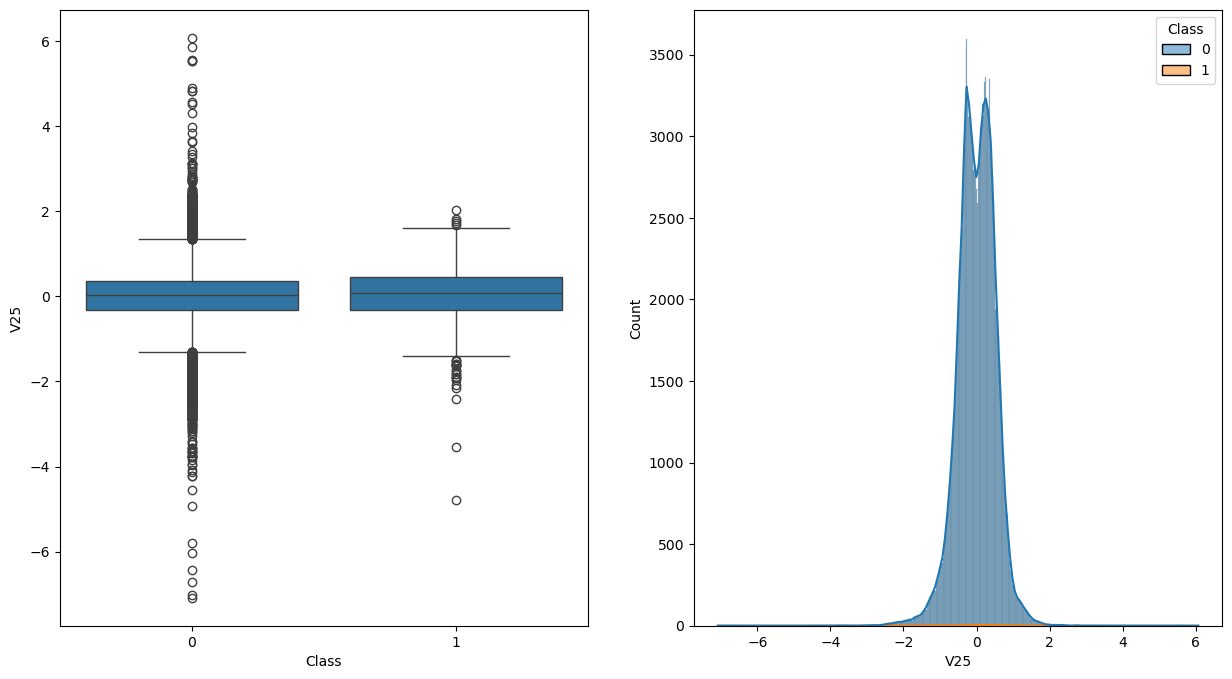

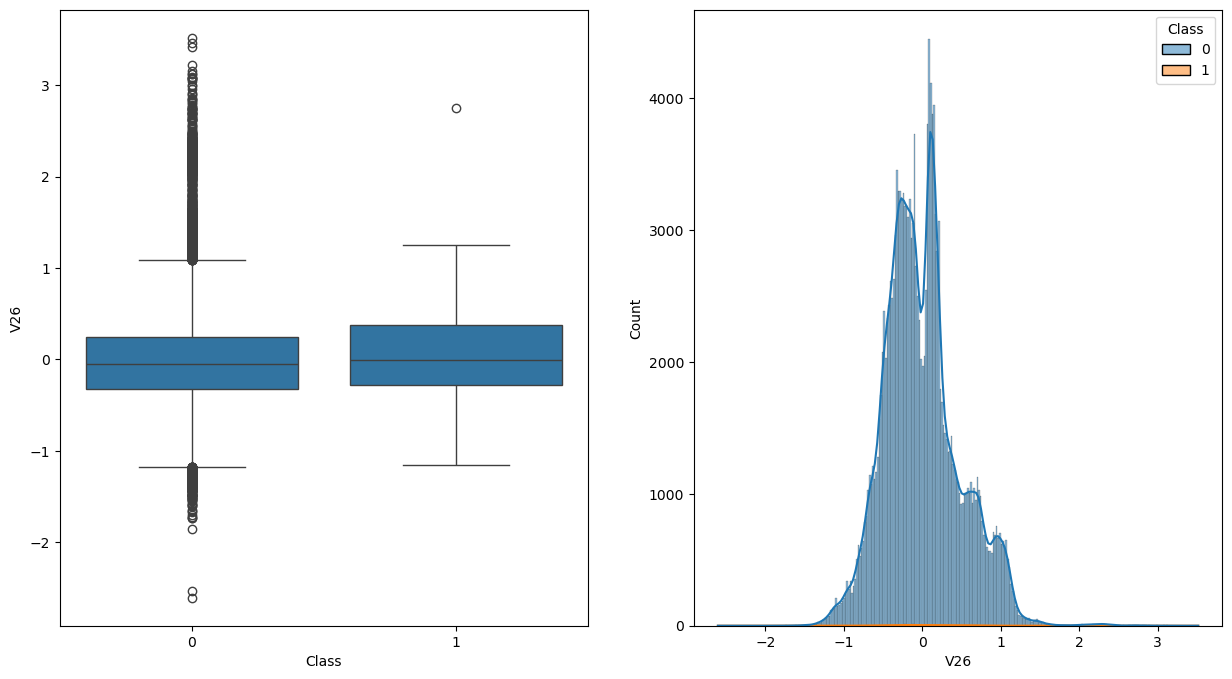

C:\Users\user\anaconda3\envs\yolov8\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


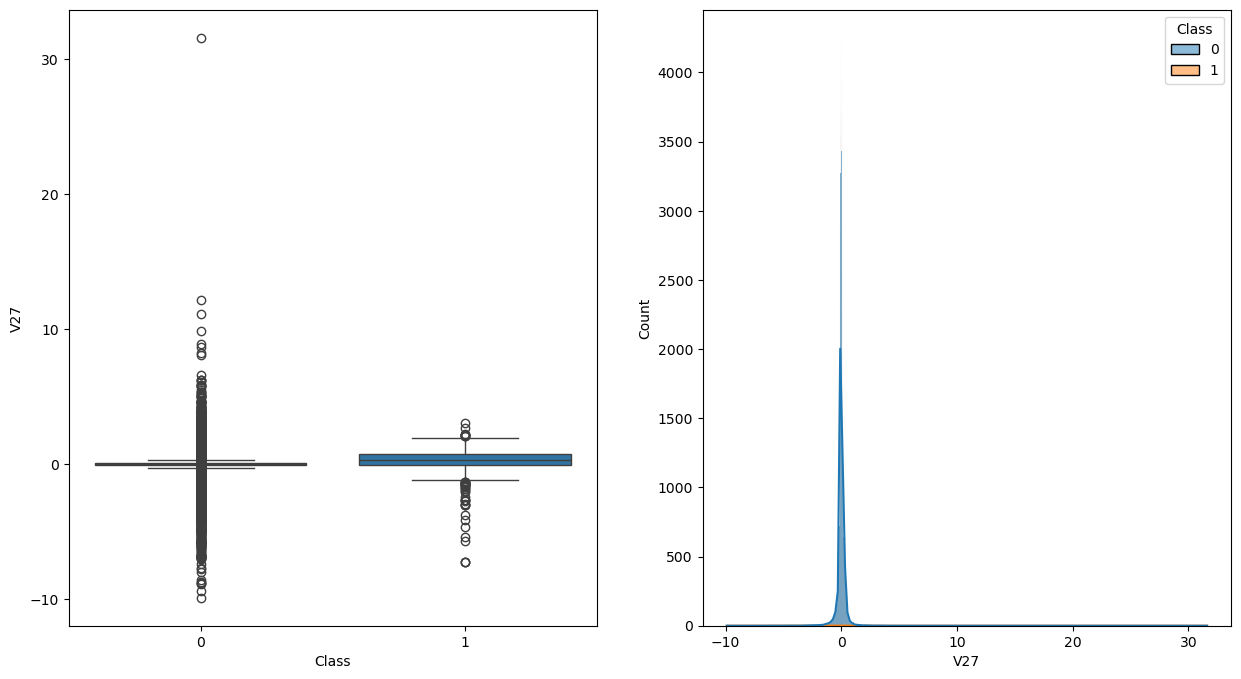

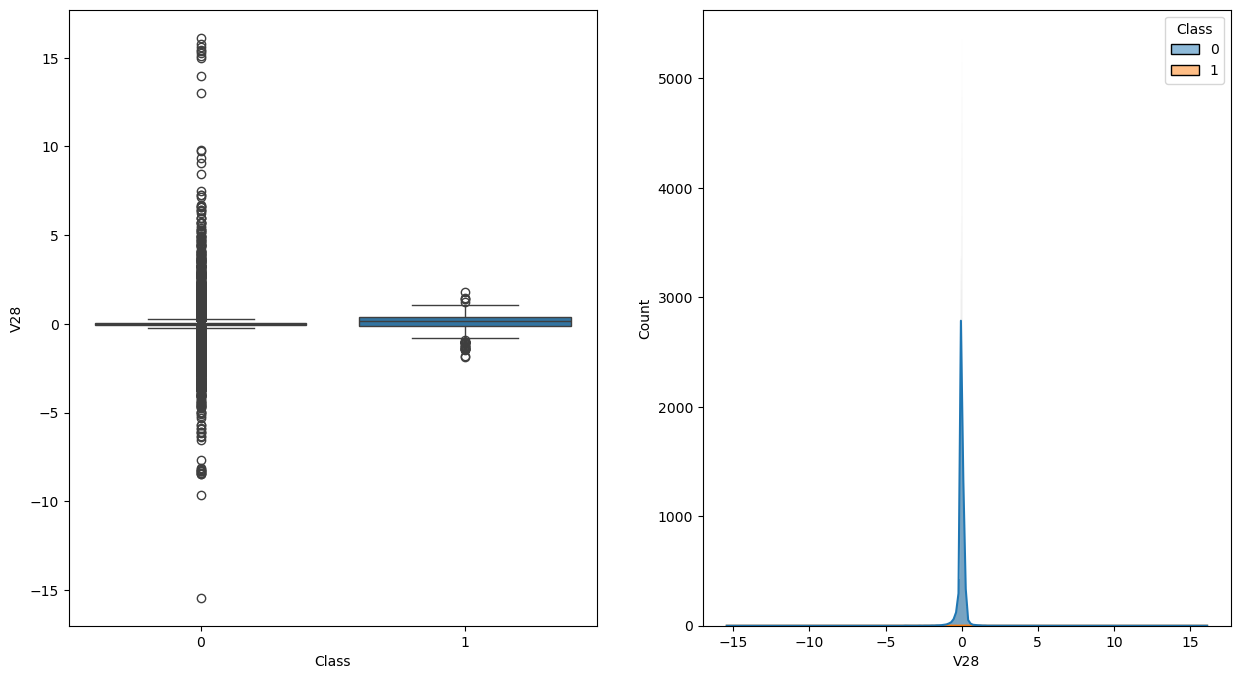

C:\Users\user\anaconda3\envs\yolov8\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


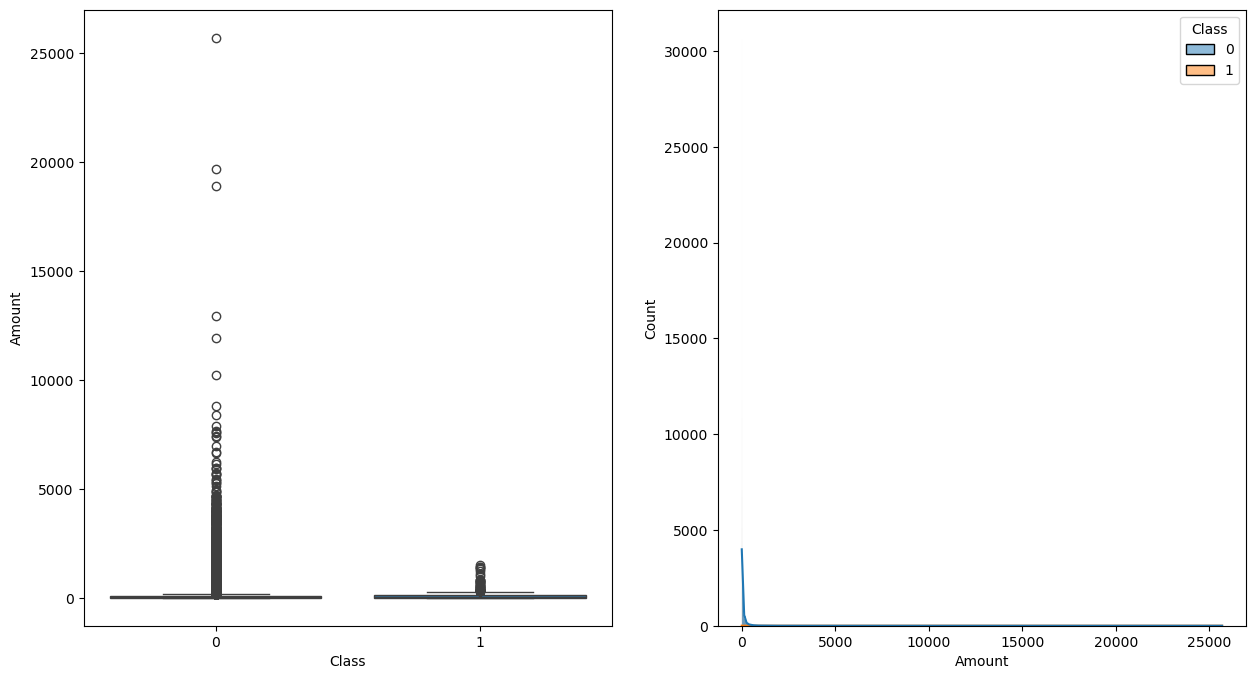

In [20]:
for col in train.columns[:-1]:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train, y=col, x='Class')
    plt.subplot(1, 2, 2)
    sns.histplot(data=train, x=col, hue='Class', kde=True)
    plt.show()

## Transactions and Fraud Counts Over Time

Line plot of total transactions per hour with fraud counts overlaid as bars.  
Helps visualize transaction activity and fraud distribution throughout the day.

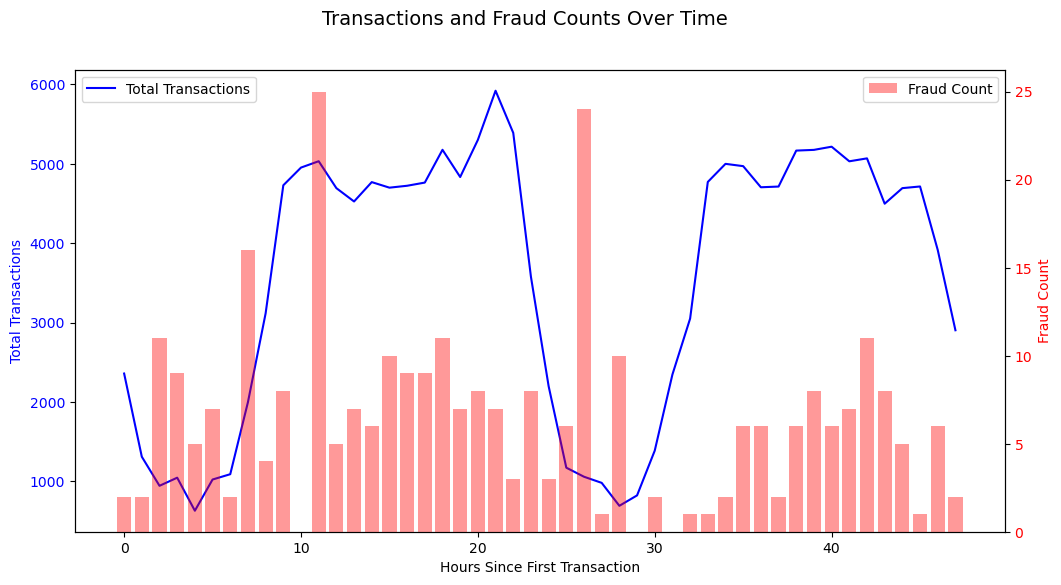

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_transactions_and_frauds(df):
    # Convert Time from seconds to hours
    df['Hour'] = (df['Time'] // 3600).astype(int)
    
    # Total transactions per hour
    total_tx = df.groupby('Hour').size()
    
    # Fraud transactions per hour
    fraud_tx = df[df['Class'] == 1].groupby('Hour').size()
    
    # Fill missing hours with zeros for fraud counts
    fraud_tx = fraud_tx.reindex(total_tx.index, fill_value=0)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot total transactions
    ax1.plot(total_tx.index, total_tx.values, color='blue', label='Total Transactions')
    ax1.set_xlabel('Hours Since First Transaction')
    ax1.set_ylabel('Total Transactions', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot fraud counts
    ax2 = ax1.twinx()
    ax2.bar(fraud_tx.index, fraud_tx.values, color='red', alpha=0.4, label='Fraud Count')
    ax2.set_ylabel('Fraud Count', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Titles and legend
    fig.suptitle('Transactions and Fraud Counts Over Time', fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

# Example usage
plot_transactions_and_frauds(train)


### Feature Correlation with Target

In [22]:
# Compute correlation of each feature with the target variable
corr_with_target = train.corr()['Class'].sort_values(ascending=False)

print(corr_with_target)

Class     1.000000
V11       0.157195
V4        0.134810
V2        0.092926
V21       0.046002
V19       0.035606
V20       0.020050
V27       0.014546
V28       0.011208
V8        0.010040
Amount    0.006298
V26       0.002070
V25      -0.001282
V22      -0.001451
V15      -0.003107
V23      -0.003241
V24      -0.005703
V13      -0.007407
Hour     -0.014336
Time     -0.014394
V6       -0.042915
V9       -0.097222
V5       -0.098536
V1       -0.105136
V18      -0.115688
V3       -0.194347
V7       -0.194594
V16      -0.200487
V10      -0.222326
V12      -0.264762
V14      -0.304561
V17      -0.332748
Name: Class, dtype: float64


## imbalanced data
- The data is **imbalanced**, but let's first try working with it as it is.
- We can start with a **Logistic Regression** model

In [3]:
def read_data():
    train = pd.read_csv(r"E:\My_Github\Credit Card Fraud Detection\data\train.csv")
    val =  pd.read_csv(r"E:\My_Github\Credit Card Fraud Detection\data\val.csv")
    test = pd.read_csv(r"E:\My_Github\Credit Card Fraud Detection\data\test.csv")
    train_val = pd.concat([train, val], ignore_index=True)
    return train, val, train_val, test

In [4]:
def labeled_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # Create DataFrame with labels
    cm_df = pd.DataFrame(cm, 
                         index=[f'{label}' for label in labels],
                         columns=[f'{label}' for label in labels])
    
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title, fontsize=14)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"AUC: {roc_auc:.4f}")
    
def evaluation_metrics(y, y_pred):
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    #print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))
    labeled_confusion_matrix(y, y_pred)

### Logistic Regression Model


train :
Precision: 0.05756137817206519
Recall: 0.9147540983606557
F1 Score: 0.10830745341614907


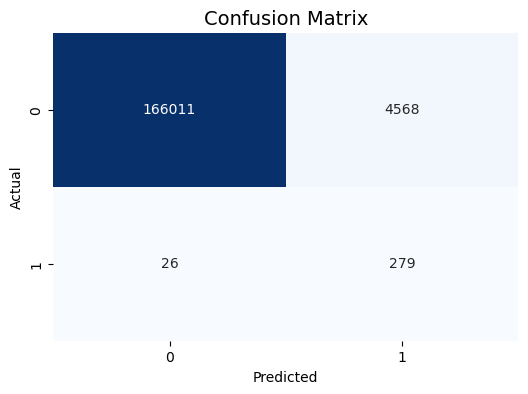


val :
Precision: 0.05225342913128674
Recall: 0.8888888888888888
F1 Score: 0.09870450339296731


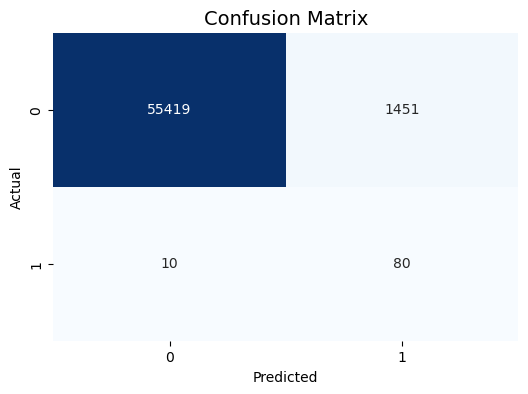

In [25]:
# Features and target
train, val, _, _ = read_data()
X_train = train.drop(columns=['Class'])  
y_train = train['Class']

X_val = val.drop(columns=['Class'])
y_val = val['Class']

scaler = StandardScaler()

# Fit on training data and transform both train and val
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')  

# Train the model
log_reg.fit(X_train, y_train)

y_train_prob = log_reg.predict_proba(X_train)[:, 1]
y_val_prob = log_reg.predict_proba(X_val)[:, 1]  

# threshold
threshold = 0.5 

y_train_pred = (y_train_prob >= threshold).astype(int) 
y_val_pred = (y_val_prob >= threshold).astype(int)  

print('\ntrain :')
evaluation_metrics(y_train, y_train_pred)
print('\nval :')
evaluation_metrics(y_val, y_val_pred)

The **F1 score** is very **low**; let's try using a **Random Forest** model.

## Random Forest Model


train :
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


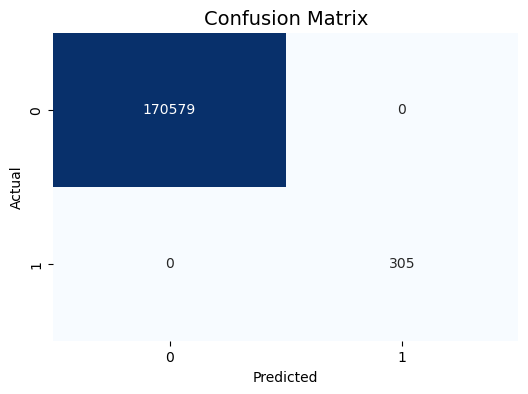


val :
Precision: 0.9552238805970149
Recall: 0.7111111111111111
F1 Score: 0.8152866242038217


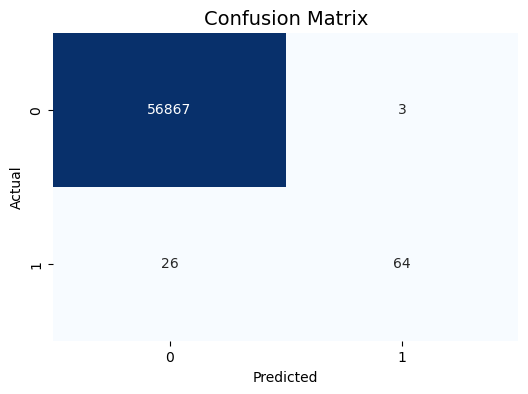

In [26]:
# Features and target
train, val, _, _ = read_data()
X_train = train.drop(columns=['Class'])  # Remove target column
y_train = train['Class']

X_val = val.drop(columns=['Class'])
y_val = val['Class']

scaler = StandardScaler()

# Fit on training data and transform both train and val
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

rf = RandomForestClassifier(random_state=42,  class_weight="balanced")

rf.fit(X_train, y_train)

y_train_prob = rf.predict_proba(X_train)[:, 1]
y_val_prob = rf.predict_proba(X_val)[:, 1]  

# threshold
threshold = 0.5 

y_train_pred = (y_train_prob >= threshold).astype(int) 
y_val_pred = (y_val_prob >= threshold).astype(int)  

print('\ntrain :')
evaluation_metrics(y_train, y_train_pred)
print('\nval :')
evaluation_metrics(y_val, y_val_pred)

The model is **overfitting**; we can adjust the parameters to **reduce** overfitting

# Finding Optimal Random Forest Parameters with GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Function for hyperparameter search
def gridsearch_rf(train):
    # Features/target
    X_train = train.drop(columns=['Class'])
    y_train = train['Class']
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # Base RF
    rf = RandomForestClassifier(
        bootstrap=True,
        random_state=42,
        class_weight="balanced"
    )
    
    # Parameter grid
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],
        'max_samples' : [None, 0.8]
    }
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='recall',
        cv=3,
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    
    # Return best estimator + scaler for validation use
    return grid_search.best_estimator_, scaler


# Function for training + evaluation using best RF
def train_eval_rf_GS(train, val, threshold=0.5):
    best_rf, scaler = gridsearch_rf(train)   # get best RF from grid search
    
    # Separate validation set
    X_val = val.drop(columns=['Class'])
    y_val = val['Class']
    
    # Scale val using train's scaler
    X_val = scaler.transform(X_val)
    
    # Predictions (probabilities)
    y_val_prob = best_rf.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_prob >= threshold).astype(int)
    
    print('\nValidation results:\n')
    evaluation_metrics(y_val, y_val_pred)
    
    return best_rf


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}

Validation results:

Precision: 0.92
Recall: 0.7666666666666667
F1 Score: 0.8363636363636363


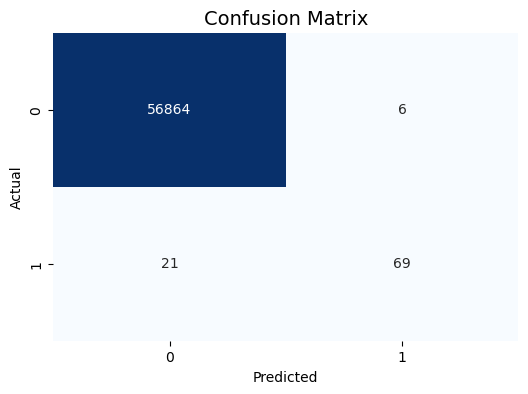

In [28]:
train, val, _, _ = read_data()
best_model = train_eval_rf_GS(train, val, threshold=0.5)

In [5]:
def train_eval_rf(train, val, threshold = 0.5):
    # Features and target
    X_train = train.drop(columns=['Class'])  # Remove target column
    y_train = train['Class']

    X_val = val.drop(columns=['Class'])
    y_val = val['Class']
    
    scaler = StandardScaler()

    # Fit on training data and transform both train and val
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    rf = RandomForestClassifier(
    n_estimators=100,    
    min_samples_split=10,  
    min_samples_leaf=5,  
    max_features="sqrt",  
    max_samples=0.8,  
    bootstrap=True,  
    class_weight="balanced",  
    random_state=42
    )

    rf.fit(X_train, y_train)
    
    y_train_prob = rf.predict_proba(X_train)[:, 1]
    y_val_prob = rf.predict_proba(X_val)[:, 1]  
     
    
    y_train_pred = (y_train_prob >= threshold).astype(int) 
    y_val_pred = (y_val_prob >= threshold).astype(int)  
    
    print('\ntrain :\n')
    evaluation_metrics(y_train, y_train_pred)
    print('\nval :\n')
    evaluation_metrics(y_val, y_val_pred)



train :

Precision: 0.9123867069486404
Recall: 0.9901639344262295
F1 Score: 0.949685534591195


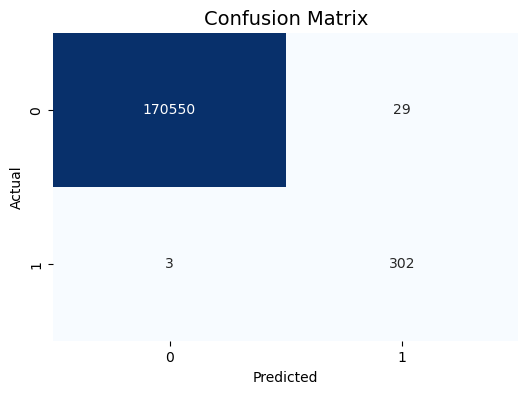


val :

Precision: 0.8690476190476191
Recall: 0.8111111111111111
F1 Score: 0.8390804597701149


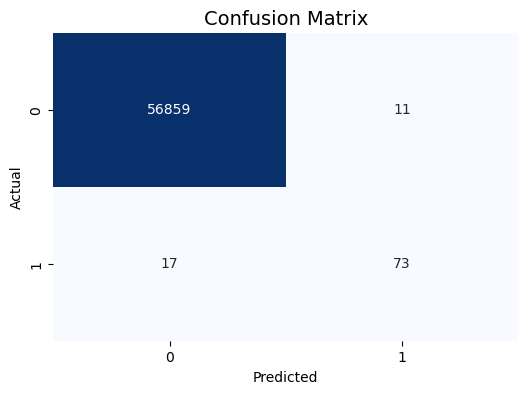

In [30]:
train, val, _, _ = read_data()
train_eval_rf(train, val)

Overfitting has been **reduced**, 
- **F1 score** on the validation set **increased** from **81.5** to **83.9** .
- **Recall** on the validation set **increased** from **71.1** to **81.1**.

# 🎯 Goal
Our primary goal is to maximize **Recall**. Why?
- **High Recall = Catch more fraudsters**
- **Missing fraud (False Negatives) is VERY expensive**
- **False alarms (False Positives) can be manually reviewed**

# Next Step: Improving Recall  

We will try to improve the **Recall score** by:  
- Adjusting the **decision threshold**  
- Applying **feature engineering**  
- Using **data balancing techniques**

## featuer engineering
- We can convert time from **seconds** to **minutes, hours** for better readability.

In [5]:
def New_features(data):
    data['Minutes'] = data['Time'] / 60
    data['Hours'] = data['Time'] / 3600

    # # AMOUNT CATEGORIES 
    # def get_amount_category(amount):
    #     if amount <= 10:
    #         return 'micro'
    #     elif amount <= 50:
    #         return 'small'
    #     elif amount <= 200:
    #         return 'medium'
    #     elif amount <= 1000:
    #         return 'large'
    #     else:
    #         return 'huge'
    
    # data['amount_category'] = data['Amount'].apply(get_amount_category)
    
    # data = pd.get_dummies(data, columns=['amount_category'], drop_first=True)
   
    return data



train :

Precision: 0.8918128654970761
Recall: 1.0
F1 Score: 0.9428129829984544


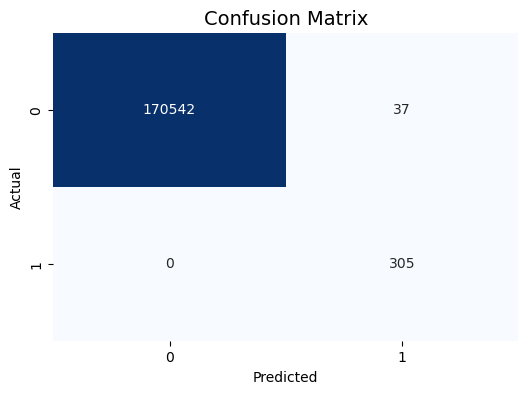


val :

Precision: 0.8604651162790697
Recall: 0.8222222222222222
F1 Score: 0.8409090909090909


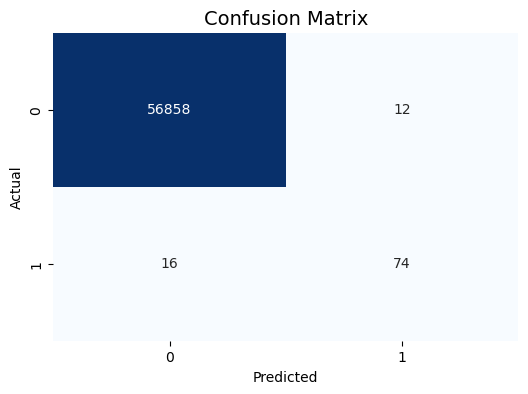

In [8]:
train, val, _, _ = read_data()
train = New_features(train)
val = New_features(val)

train_eval_rf(train, val, threshold = 0.32)

- After generating new features, the **Recall on the validation set** improved from **81.1% → 82.2%**.  

# Handling Class Imbalance in Fraud Detection
- **Oversampling** → Increase the number of fraud (minority class) samples (SMOTE)  
- **Undersampling** → Reduce the number of non-fraud (majority class) samples (RandomUnderSampler)  
- **Hybrid (Over + Under Sampling)** → Combine both methods to achieve better balance 

## Oversampling

In [6]:
def over_sample(X, y):
    counter = Counter(y)                   # counter({0: 170579 , 1: 305})
    factor, majoirty_size = 10, counter[0]
    new_size = int(majoirty_size/factor)
    
    oversample = SMOTE(random_state=42, sampling_strategy={1: new_size}, k_neighbors=2)
    X_os, y_os = oversample.fit_resample(X, y)
    
    return X_os, y_os

## Undersampling

In [34]:
def under_sample(X, y):
    counter = Counter(y)                 # Counter({0: 170579, 1: 305})
    factor, majoirty_size = 10, counter[0]
    new_size = int(majority_size / factor)

    undersample = RandomUnderSampler(random_state=42, sampling_strategy={0: new_size, 1: counter[1]})
    X_us, y_us = undersample.fit_resample(X, y)

    return X_us, y_us

## under_over_sample

In [35]:
def under_over_sample(X, y):
    counter = Counter(y)                   # counter({0: 170579 , 1: 305})
    min_size = int(counter[0] // 20)      
    maj_size = int(counter[0] * 0.88)        
    
    oversample = SMOTE(random_state=42, sampling_strategy={1: min_size}, k_neighbors=2)
    undersample = RandomUnderSampler(random_state=42, sampling_strategy={0: maj_size})
    
    pip = imb_pipeline(steps=[("over", oversample), ("under", undersample)])
    
    X_ovs, y_ovs = pip.fit_resample(X, y)
    
    return X_ovs, y_ovs

# Sampling Strategy Results
I experimented with **Oversampling**, **Undersampling**, and a combined **Over+Under Sampling** approach.  
Among these, **Oversampling (SMOTE)** gave the best results, as it increased the number of fraud cases while preserving all majority class samples.  
This helped the model achieve higher **Recall**, which is our primary goal in fraud detection.


In [10]:
def train_eval_rf_oversampling(train, val, threshold = 0.5):
    # Features and target
    X_train = train.drop(columns=['Class'])  # Remove target column
    y_train = train['Class']

    X_val = val.drop(columns=['Class'])
    y_val = val['Class']
    
    scaler = StandardScaler()

    # Fit on training data and transform both train and val
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # oversampling
    X_train , y_train = over_sample(X_train, y_train)

    rf = RandomForestClassifier(
    n_estimators=100,    
    min_samples_split=10,  
    min_samples_leaf=5,  
    max_features="sqrt",  
    max_samples=0.8,  
    bootstrap=True,  
    class_weight="balanced",  
    random_state=42
    )

    rf.fit(X_train, y_train)
    
    y_train_prob = rf.predict_proba(X_train)[:, 1]
    y_val_prob = rf.predict_proba(X_val)[:, 1]  
     
    
    y_train_pred = (y_train_prob >= threshold).astype(int) 
    y_val_pred = (y_val_prob >= threshold).astype(int)  
    
    print('\ntrain :\n')
    evaluation_metrics(y_train, y_train_pred)
    print('\nval :\n')
    evaluation_metrics(y_val, y_val_pred)


train :

Precision: 0.9967858812529219
Recall: 1.0
F1 Score: 0.9983903538294946


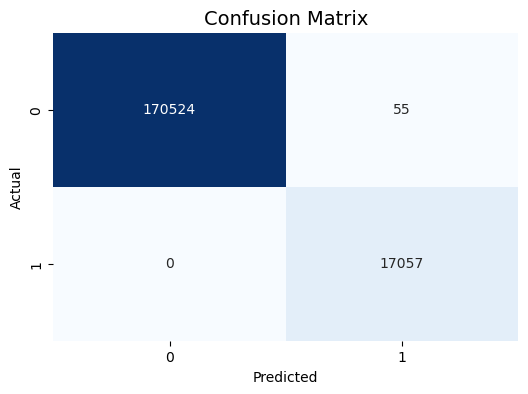


val :

Precision: 0.8020833333333334
Recall: 0.8555555555555555
F1 Score: 0.8279569892473119


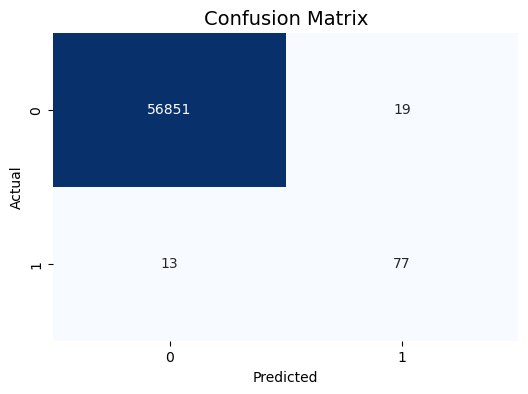

In [11]:
train, val, _, _ = read_data()
train = New_features(train)
val = New_features(val)

train_eval_rf_oversampling(train, val, threshold = 0.32)

- After Oversampling, the **Recall on the validation set** improved from **82.2% → 85.5%**.  

# XGBoost

In [12]:
def train_eval_xgb(train, val, threshold = 0.5):
    # Features and target
    X_train = train.drop(columns=['Class'])  # Remove target column
    y_train = train['Class']

    X_val = val.drop(columns=['Class'])
    y_val = val['Class']
    
    scaler = StandardScaler()

    # Fit on training data and transform both train and val
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)


    xgb_model = XGBClassifier(
        n_estimators=400,         
        max_depth=6,              
        learning_rate=0.09,        
        subsample=0.8,            
        colsample_bytree=0.7,     
        scale_pos_weight=1000 * (len(y_train) - sum(y_train)) / sum(y_train),  # handle imbalance
        random_state=42,
        eval_metric="aucpr",    
        objective="binary:logistic"
        
    )

    xgb_model.fit(
    X_train, y_train,
    #eval_set=[(X_val, y_val)],       
    #verbose=True
     )
    
    y_train_prob = xgb_model.predict_proba(X_train)[:, 1]
    y_val_prob = xgb_model.predict_proba(X_val)[:, 1] 
     
    
    y_train_pred = (y_train_prob >= threshold).astype(int) 
    y_val_pred = (y_val_prob >= threshold).astype(int) 
    
    print('\ntrain :\n')
    evaluation_metrics(y_train, y_train_pred)
    print('\nval :\n')
    evaluation_metrics(y_val, y_val_pred)


train :

Precision: 0.993485342019544
Recall: 1.0
F1 Score: 0.9967320261437909


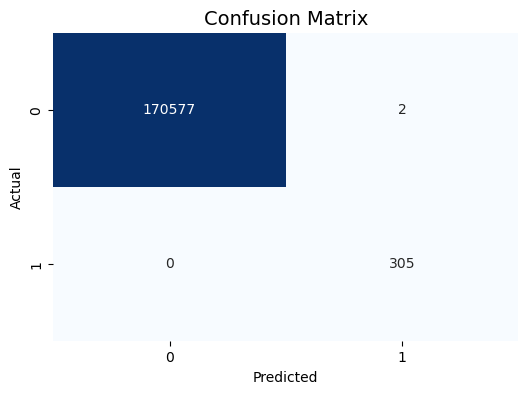


val :

Precision: 0.8444444444444444
Recall: 0.8444444444444444
F1 Score: 0.8444444444444444


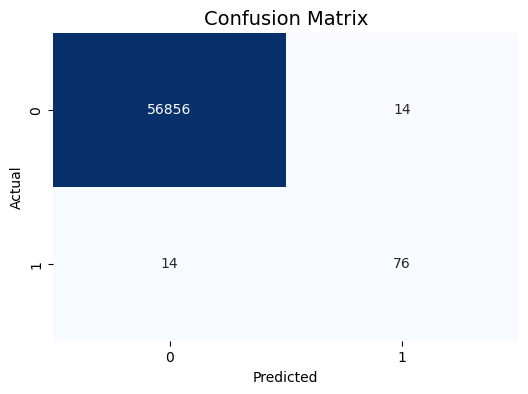

In [13]:
train, val, _, _ = read_data()
train = New_features(train)
val = New_features(val)

train_eval_xgb(train, val, threshold = 0.26)

# CatBoost model

In [49]:
def train_eval_cat(train, val, threshold = 0.5):
    # Features and target
    X_train = train.drop(columns=['Class'])  
    y_train = train['Class']

    X_val = val.drop(columns=['Class'])
    y_val = val['Class']
    
    scaler = StandardScaler()

    # Fit on training data and transform both train and val
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    cat_model = CatBoostClassifier(
        iterations=200,              
        learning_rate=0.05,           
        depth=6,                      
        l2_leaf_reg=5,                
        eval_metric="Recall",         
        loss_function="Logloss",      
        class_weights=[1, 120],       
        bagging_temperature=0.2,      
        border_count=256,             
        verbose=0,                   
        random_seed=42
    )

    cat_model.fit(X_train, y_train)
    
    y_train_prob = cat_model.predict_proba(X_train)[:, 1]
    y_val_prob = cat_model.predict_proba(X_val)[:, 1]  

    y_train_pred = (y_train_prob >= threshold).astype(int) 
    y_val_pred = (y_val_prob >= threshold).astype(int)  
    
    print('\ntrain :\n')
    evaluation_metrics(y_train, y_train_pred)
    print('\nval :\n')
    evaluation_metrics(y_val, y_val_pred)


train :

Precision: 0.7984293193717278
Recall: 1.0
F1 Score: 0.8879184861717613


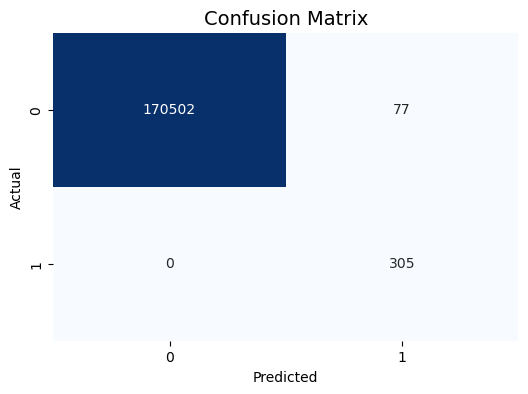


val :

Precision: 0.8
Recall: 0.8444444444444444
F1 Score: 0.8216216216216217


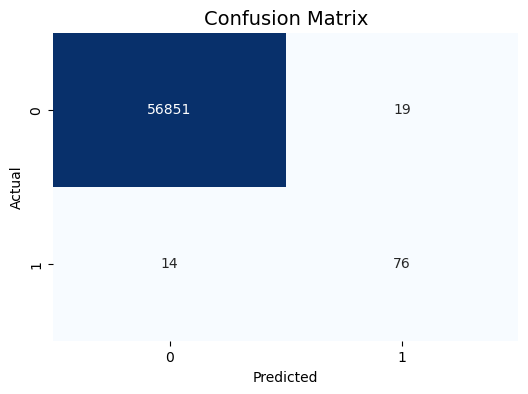

In [64]:
train, val, _, _ = read_data()
train = New_features(train)
val = New_features(val)

train_eval_cat(train, val, threshold = 0.36)

# Stacking Ensemble

- Train base models (**RandomForest**, **XGBoost**, **CatBoost**) on the **TRAIN** data.  
- Collect their predicted probabilities along with extra engineered features:  
  `Hours`, `V17`, `V14`, `V12`, `V11`, `V4`.  
- Train a **second-level meta-model** (LogisticRegression) that learns how to combine  
  these predictions and features.  
- Evaluate the stacked model on the **VAL** data.

In [25]:
def stacking_ensemble(train, val, threshold=0.3):
    # -----------------
    # Split features & target
    X_train, y_train = train.drop(columns=['Class']), train['Class']
    X_val, y_val     = val.drop(columns=['Class']),   val['Class']

    # Scale main features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # -----------------
    # RandomForest with oversampling
    X_rf_train_os, y_rf_train_os = over_sample(X_train_scaled, y_train)

    rf = RandomForestClassifier(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        max_samples=0.8,
        bootstrap=True,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_rf_train_os, y_rf_train_os)

    # -----------------
    # XGBoost
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.09,
        subsample=0.8,
        colsample_bytree=0.7,
        scale_pos_weight=1000 * (len(y_train) - sum(y_train)) / sum(y_train),
        random_state=42,
        eval_metric="aucpr",
        objective="binary:logistic"
    )
    xgb.fit(X_train_scaled, y_train)

    # -----------------
    # CatBoost
    cat = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=5,
        eval_metric="Recall",
        loss_function="Logloss",
        class_weights=[1, 120],
        bagging_temperature=0.2,
        border_count=256,
        verbose=0,
        random_seed=42
    )
    cat.fit(X_train_scaled, y_train)

    # -----------------
    # Scale extra features
    extra_scaler = StandardScaler()
    extra_features_train = extra_scaler.fit_transform(
        train[['Hours', 'V17','V14','V12', 'V11','V4']]
    )
    extra_features_val = extra_scaler.transform(
        val[['Hours','V17','V14','V12', 'V11','V4']]
    )

    # -----------------
    # Meta-features for TRAIN
    rf_train_prob  = rf.predict_proba(X_train_scaled)[:, 1]
    xgb_train_prob = xgb.predict_proba(X_train_scaled)[:, 1]
    cat_train_prob = cat.predict_proba(X_train_scaled)[:, 1]

    meta_X_train = np.column_stack((rf_train_prob, xgb_train_prob, cat_train_prob, extra_features_train))
    meta_y_train = y_train

    # Train meta-learner
    meta_model = LogisticRegression(
        max_iter=100,
        class_weight={0: 1, 1: 50},
        random_state=42,
        verbose=0
    )
    meta_model.fit(meta_X_train, meta_y_train)

    # -----------------
    # Meta-features for VAL
    rf_val_prob  = rf.predict_proba(X_val_scaled)[:, 1]
    xgb_val_prob = xgb.predict_proba(X_val_scaled)[:, 1]
    cat_val_prob = cat.predict_proba(X_val_scaled)[:, 1]

    meta_X_val = np.column_stack((rf_val_prob, xgb_val_prob, cat_val_prob, extra_features_val))

    # -----------------
    # Predictions
    meta_train_prob = meta_model.predict_proba(meta_X_train)[:, 1]
    meta_train_pred = (meta_train_prob >= threshold).astype(int)

    meta_val_prob = meta_model.predict_proba(meta_X_val)[:, 1]
    meta_val_pred = (meta_val_prob >= threshold).astype(int)

    # -----------------
    # Evaluate
    print("\n---- Meta Model ----")
    print('\nTrain:\n')
    evaluation_metrics(meta_y_train, meta_train_pred)

    print('\nVal:\n')
    evaluation_metrics(y_val, meta_val_pred)

    return rf, xgb, cat, meta_model, scaler, extra_scaler



---- Meta Model ----

Train:

Precision: 0.9838709677419355
Recall: 1.0
F1 Score: 0.991869918699187


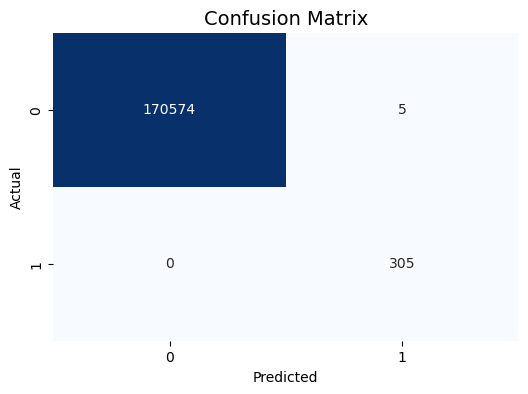


Val:

Precision: 0.8928571428571429
Recall: 0.8333333333333334
F1 Score: 0.8620689655172413


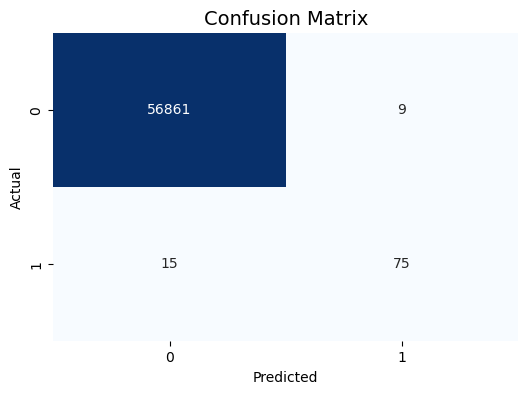

In [31]:
train, val, _, _ = read_data()
train = New_features(train)
val = New_features(val)

rf, xgb, cat, meta_model, scaler, extra_scaler = stacking_ensemble(train, val, threshold=0.75)

## Stacking Ensemble (Train+Val combined)

- Combine **train** and **val** into a single dataset (`train_val`).
- Train base models (**RandomForest**, **XGBoost**, **CatBoost**) on `train_val`.
- Use their predicted probabilities + extra engineered features  
  (`Hours`, `V17`, `V14`, `V12`, `V11`, `V4`) as inputs to a **meta-model** (LogisticRegression).
- The meta-model is trained on `train_val` and evaluated on the **test set**.

In [47]:
def stacking_ensemble2(train_val, test, threshold=0.5):
    # -----------------
    # Split features & target
    X_train, y_train = train_val.drop(columns=['Class']), train_val['Class']
    X_test, y_test   = test.drop(columns=['Class']),     test['Class']

    # Scale main features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # -----------------
    # RandomForest with oversampling
    X_rf_train_os, y_rf_train_os = over_sample(X_train_scaled, y_train)

    rf = RandomForestClassifier(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        max_samples=0.8,
        bootstrap=True,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_rf_train_os, y_rf_train_os)

    # -----------------
    # XGBoost
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.09,
        subsample=0.8,
        colsample_bytree=0.7,
        scale_pos_weight=1000 * (len(y_train) - sum(y_train)) / sum(y_train),
        random_state=42,
        eval_metric="aucpr",
        objective="binary:logistic"
    )
    xgb.fit(X_train_scaled, y_train)

    # -----------------
    # CatBoost
    cat = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=5,
        eval_metric="Recall",
        loss_function="Logloss",
        class_weights=[1, 120],
        bagging_temperature=0.2,
        border_count=256,
        verbose=0,
        random_seed=42
    )
    cat.fit(X_train_scaled, y_train)

    # -----------------
    # Scale extra features ('Hours', 'V17','V14','V12', 'V11','V4')
    extra_scaler = StandardScaler()
    extra_features_train = extra_scaler.fit_transform(
        train_val[['Hours', 'V17','V14','V12', 'V11','V4']]
    )
    extra_features_test = extra_scaler.transform(
        test[['Hours','V17','V14','V12', 'V11','V4']]
    )

    # -----------------
    # Build meta-features for TRAIN
    rf_train_prob  = rf.predict_proba(X_train_scaled)[:, 1]
    xgb_train_prob = xgb.predict_proba(X_train_scaled)[:, 1]
    cat_train_prob = cat.predict_proba(X_train_scaled)[:, 1]

    meta_X_train = np.column_stack((rf_train_prob, xgb_train_prob, cat_train_prob, extra_features_train))
    meta_y_train = y_train

    # Train meta-learner
    meta_model = LogisticRegression(
        max_iter=100,
        class_weight={0: 1, 1: 50},
        random_state=42,
        verbose=0
    )
    meta_model.fit(meta_X_train, meta_y_train)

    # -----------------
    # Evaluate on TRAIN_VAL
    meta_train_prob = meta_model.predict_proba(meta_X_train)[:, 1]
    meta_train_pred = (meta_train_prob >= threshold).astype(int)

    print("\n----meta model----:")
    print('\ntrain_val :\n')
    evaluation_metrics(y_train, meta_train_pred)

    print("\n----meta model train_val ROC_curve----:")
    plot_roc_curve(y_train, meta_train_pred)
          

    # -----------------
    # Build meta-features for TEST
    rf_test_prob  = rf.predict_proba(X_test_scaled)[:, 1]
    xgb_test_prob = xgb.predict_proba(X_test_scaled)[:, 1]
    cat_test_prob = cat.predict_proba(X_test_scaled)[:, 1]

    meta_X_test = np.column_stack((rf_test_prob, xgb_test_prob, cat_test_prob, extra_features_test))

    # Test predictions
    meta_test_prob = meta_model.predict_proba(meta_X_test)[:, 1]
    meta_test_pred = (meta_test_prob >= threshold).astype(int)

    print('\ntest :\n')
    evaluation_metrics(y_test, meta_test_pred)

    print("\n----Final Test Evaluation ROC_curve----:")
    plot_roc_curve(y_test, meta_test_pred)

    return rf, xgb, cat, meta_model, scaler, extra_scaler


----meta model----:

train_val :

Precision: 0.9825870646766169
Recall: 1.0
F1 Score: 0.9912170639899623


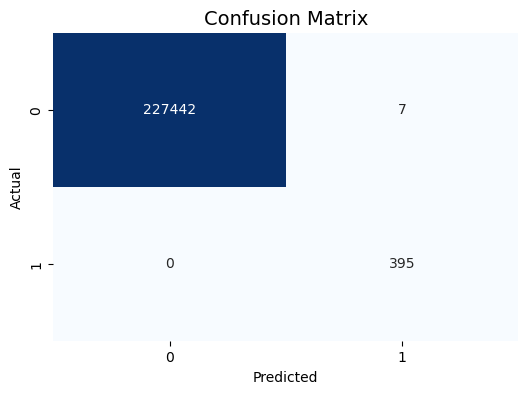


----meta model train_val ROC_curve----:


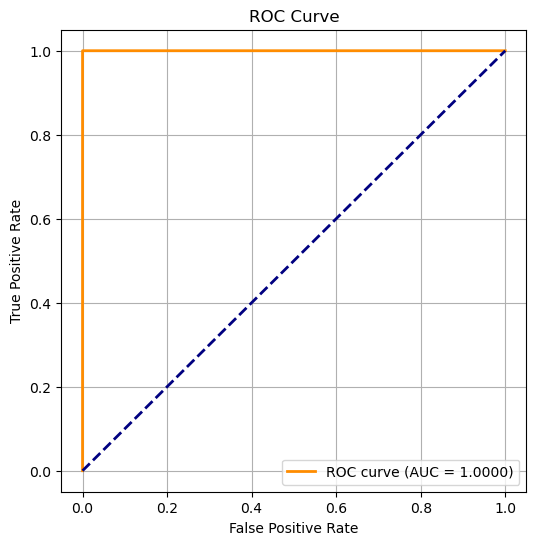

AUC: 1.0000

test :

Precision: 0.8269230769230769
Recall: 0.8865979381443299
F1 Score: 0.8557213930348259


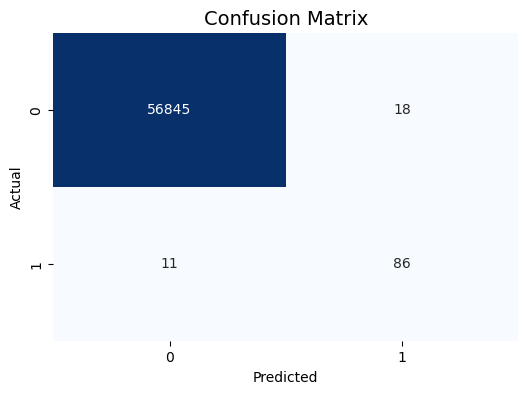


----Final Test Evaluation ROC_curve----:


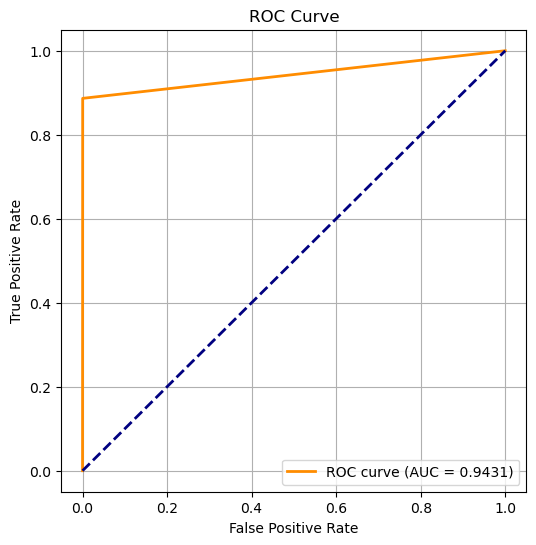

AUC: 0.9431


In [48]:
# Load and process data 
_, _, train_val, test = read_data()

train_val = New_features(train_val)
test = New_features(test)

rf, xgb, cat, meta_model, scaler, extra_scaler = stacking_ensemble2(train_val, test, threshold=0.75)

# Output of test
- Recall: **88.65 %**
- F1 Score: **85.57 %**